In [ ]:
!pip install tiktoken lxml sentencepiece llama-index datasets sentence_transformers langchain

INFO: pip is looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.3/303.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!pip install chromadb

In [ ]:
# 설치 후 런타임 > 세션 다시 시작 권장
!pip install -U bitsandbytes accelerate

# Naive RAG

이 코드는 IMDB 영화 리뷰 데이터셋을 불러와서 TF-IDF 벡터화를 수행하는 과정입니다. 먼저 pandas를 사용해 CSV 파일을 읽어들이는데, 파일이 없으면 자동으로 GitHub에서 다운로드하고 압축을 해제합니다. 전체 데이터셋 중 처음 5000개의 리뷰만 선택하여 `df.iloc[:5000,:]`로 메모리 효율성을 고려합니다.

핵심은 `TfidfVectorizer`를 사용한 텍스트 벡터화입니다. 여기서 `max_features=1000` 파라미터는 가장 중요한 1000개의 단어만 선택하도록 제한합니다. `fit_transform(df['review'])`는 두 가지 작업을 동시에 수행하는데, 먼저 전체 리뷰 텍스트에서 어휘 사전을 학습하고(fit), 그 다음 각 문서를 TF-IDF 가중치 벡터로 변환합니다(transform).

TF-IDF는 Term Frequency-Inverse Document Frequency의 약자로, 특정 단어가 한 문서에서 얼마나 자주 등장하는지(TF)와 전체 문서에서 얼마나 희귀한지(IDF)를 모두 고려합니다. 예를 들어 "zombie"라는 단어가 어떤 리뷰에 많이 등장하지만 다른 리뷰에는 거의 없다면 높은 TF-IDF 값을 가지게 됩니다. 결과로 생성된 `tfidf_matrix`는 희소 행렬(sparse matrix) 형태인데, 이를 `toarray()`로 밀집 배열로 변환하고 DataFrame으로 만들어 각 단어별 TF-IDF 점수를 열로 가진 테이블을 생성합니다. 이렇게 생성된 수치 벡터는 이후 코사인 유사도 계산 등 다양한 문서 검색 작업의 기반이 됩니다.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#this for unzip and read the file
try:
    df=pd.read_csv("IMDB Dataset.csv")
except:
    !wget https://github.com/SalvatoreRa/tutorial/blob/main/datasets/IMDB.zip?raw=true
    !unzip IMDB.zip?raw=true

# Load the dataset
df = pd.read_csv("IMDB Dataset.csv")
df = df.iloc[:5000,:]

# Display the first few rows of the dataframe
print(df.head())

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform
tfidf_matrix = tfidf_vectorizer.fit_transform(df['review'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())



--2025-10-17 07:01:58--  https://github.com/SalvatoreRa/tutorial/blob/main/datasets/IMDB.zip?raw=true
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/SalvatoreRa/tutorial/raw/refs/heads/main/datasets/IMDB.zip [following]
--2025-10-17 07:01:59--  https://github.com/SalvatoreRa/tutorial/raw/refs/heads/main/datasets/IMDB.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SalvatoreRa/tutorial/refs/heads/main/datasets/IMDB.zip [following]
--2025-10-17 07:01:59--  https://raw.githubusercontent.com/SalvatoreRa/tutorial/refs/heads/main/datasets/IMDB.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.1

사용자 쿼리와 문서 간의 유사도를 계산하여 관련성이 높은 리뷰를 찾는 검색 과정입니다. 먼저 "I want to watch a movie about zombie"라는 자연어 쿼리를 정의하고, 이전에 학습된 `tfidf_vectorizer.transform()`을 사용해 동일한 1000차원 벡터 공간으로 변환합니다. 여기서 중요한 점은 `fit_transform()`이 아닌 `transform()`만 사용한다는 것인데, 이는 이미 학습된 어휘 사전을 그대로 사용하여 쿼리를 기존 문서들과 같은 기준으로 벡터화하기 위함입니다.

`cosine_similarity()` 함수는 쿼리 벡터와 모든 문서 벡터 간의 코사인 유사도를 계산합니다. 코사인 유사도는 두 벡터 사이의 각도를 측정하는 방식으로, 벡터의 크기보다는 방향성에 초점을 맞춥니다. 값의 범위는 -1에서 1까지이며, 1에 가까울수록 더 유사함을 의미합니다. `flatten()`은 결과를 1차원 배열로 평탄화하여 각 문서별 유사도 점수를 얻습니다.

계산된 유사도 점수를 원본 데이터프레임에 새로운 열로 추가한 후, `sort_values(by='cosine_similarity', ascending=False)`로 유사도가 높은 순서대로 정렬합니다. 이렇게 하면 "zombie"라는 키워드가 포함되거나 관련성이 높은 리뷰들이 상위에 배치됩니다. `reset_index(drop=True)`는 정렬 후 인덱스를 0부터 다시 매겨 깔끔한 순위 목록을 만듭니다. 이것이 바로 가장 기본적인 형태의 RAG(Retrieval-Augmented Generation)에서 검색(Retrieval) 단계에 해당하며, TF-IDF와 코사인 유사도만으로도 의미있는 문서 검색이 가능함을 보여줍니다.

In [ ]:
# Define the query
query = "I want to watch a movie about zombie"

# Transform the query using the same TF-IDF vectorizer
query_tfidf = tfidf_vectorizer.transform([query])

# Calculate cosine similarity between the query and all documents
cosine_similarities = cosine_similarity(query_tfidf, tfidf_matrix).flatten()

df['cosine_similarity'] = cosine_similarities

reranked_df = df.sort_values(by='cosine_similarity',
                             ascending=False).reset_index(drop=True)

reranked_df

,review,sentiment,cosine_similarity
0,If you want to waste a small portion of your l...,negative,0.589198
1,This movie is god awful. Not one quality to th...,negative,0.483662
2,"Now, I'm a big fan of Zombie movies. I admit Z...",negative,0.463848
3,"""Revolt of the Zombies"" proves that having the...",negative,0.360548
4,I haven't had a chance to view the previous fi...,negative,0.343682
...,...,...,...
4995,I was rooting for this film as it's a remake o...,negative,0.000000
4996,Maybe not the most original way of telling a s...,positive,0.000000
4997,If you need cheering up on a cold weekday even...,positive,0.000000
4998,"they (dueringer, dorfer) are good stand-up com...",negative,0.000000


In [ ]:
#give a look in detail to the first example
reranked_df.iloc[0,0]

'If you want to waste a small portion of your life sit in front of this predictable zombie film. It fails at the first post by not being scary OR funny. It is a dull grey movie that I guess went straight to video. Hammy and tongue in cheek acting leave a sour taste in the mouth. If you want to watch a poor but still watchable recent zombie film watch Diary of the Dead. Poor special effects, school level script. Zombie films work if they have a moral point or even a political point . This movie has nothing, there is no worthy point that zombification underscores. This is as thrilling and convincing as a Republican Convention, no sorry watching the Republican Convention would be a better example of a Zombie movie.'

TF-IDF와 BM25 알고리즘의 점수 계산 방식을 시각적으로 비교하는 코드입니다. 먼저 `np.arange(1, 101)`로 1부터 100까지의 단어 빈도수를 생성하여 x축 값으로 사용합니다. TF-IDF의 term frequency 부분은 `np.log(1 + frequencies)`로 계산되는데, 로그 함수를 사용하기 때문에 빈도가 증가할수록 점수 증가폭이 완만해지는 특징을 가집니다.

BM25는 정보 검색 분야에서 TF-IDF보다 더 효과적인 것으로 알려진 랭킹 함수입니다. `k1=1.5`는 term frequency의 포화도를 조절하는 파라미터로, 값이 클수록 빈도에 따른 점수 증가가 더 완만해집니다. `b=0.75`는 문서 길이 정규화 정도를 결정하는데, 0이면 길이를 무시하고 1이면 완전히 정규화합니다. `avg_dl=50`은 평균 문서 길이를 의미합니다.

BM25 공식 `((k1 + 1) * frequencies) / (k1 * (1 - b + b * frequencies / avg_dl) + frequencies)`를 보면 분자는 빈도에 선형적으로 증가하지만, 분모의 정규화 항이 빈도가 높아질수록 점수 증가를 억제합니다. 이는 단어가 너무 많이 반복되어도 점수가 무한정 증가하지 않도록 포화 효과를 구현한 것입니다.

두 곡선을 그래프로 그리면 TF-IDF는 계속 증가하는 로그 곡선을 보이지만, BM25는 특정 지점 이후 거의 평탄해지는 포화 곡선을 보입니다. `plt.annotate()`로 각 곡선에 레이블을 추가하여 어느 것이 어느 알고리즘인지 명확히 표시합니다. 이 시각화는 BM25가 spam 문서처럼 특정 키워드를 과도하게 반복하는 경우에도 점수가 무한정 높아지지 않아 더 robust한 랭킹을 제공함을 보여줍니다.

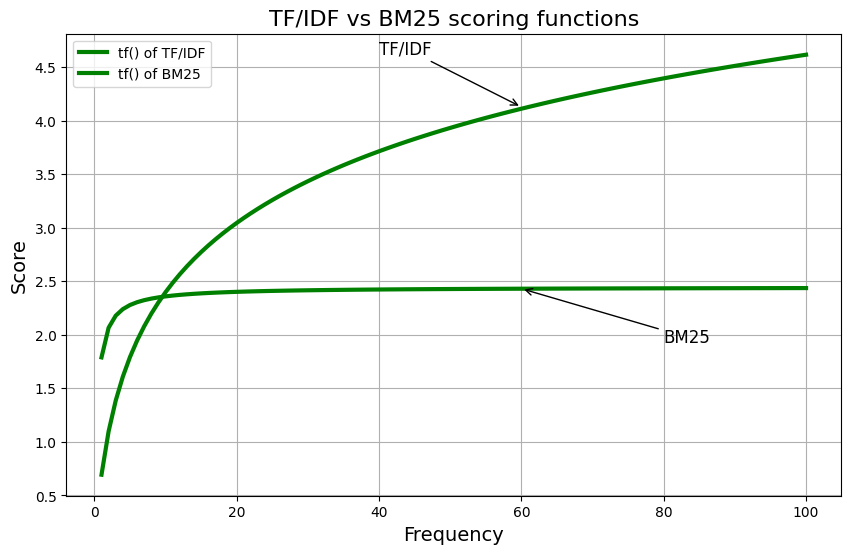

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate term frequencies
frequencies = np.arange(1, 101)

# Calculate TF-IDF scores (using log(1 + frequency))
tfidf_scores = np.log(1 + frequencies)

# Calculate BM25 scores
k1 = 1.5  # typically between 1.2 and 2.0
b = 0.75  # typically between 0.5 and 0.75
avg_dl = 50  # average document length

# BM25 formula
bm25_scores = ((k1 + 1) * frequencies) / (k1 * (1 - b + b * frequencies / avg_dl) + frequencies)

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(frequencies, tfidf_scores, label='tf() of TF/IDF', color='green', linewidth=3)
plt.plot(frequencies, bm25_scores, label='tf() of BM25', color='green', linewidth=3)


plt.annotate('TF/IDF', xy=(60, tfidf_scores[60]), xytext=(40, tfidf_scores[60] + 0.5),
             arrowprops=dict(arrowstyle="->", color='black'), fontsize=12, color='black')
plt.annotate('BM25', xy=(60, bm25_scores[60]), xytext=(80, bm25_scores[60] - 0.5),
             arrowprops=dict(arrowstyle="->", color='black'), fontsize=12, color='black')

plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('TF/IDF vs BM25 scoring functions', fontsize=16)

plt.grid(True)

plt.legend()
plt.savefig('tfidf_bm25.jpg', format='jpeg')
plt.show()


BM25 알고리즘의 두 가지 핵심 파라미터인 k1과 b의 영향을 각각 시각화해보겠습니다. 1부터 100까지의 단어 빈도수를 생성하고 평균 문서 길이를 50으로 설정한 후, `plt.subplots(1, 2)`로 두 개의 서브플롯을 나란히 배치하여 파라미터별 효과를 비교합니다.

왼쪽 그래프에서는 k1 파라미터의 변화를 관찰합니다. k1 값을 0, 1.5, 3.0으로 변경하면서 b는 0.75로 고정합니다. k1이 0일 때는 빈도에 관계없이 점수가 거의 일정하게 유지되고, k1이 증가할수록 빈도에 따른 점수 증가가 더 완만해집니다. k1=1.5는 표준 설정으로 적절한 포화 효과를 제공하며, k1=3.0은 더 강한 포화를 적용하여 고빈도 단어의 점수를 더 억제합니다.

오른쪽 그래프에서는 b 파라미터의 영향을 분석합니다. k1을 1.5로 고정하고 b 값을 0, 0.75, 1.0으로 변화시킵니다. b=0일 때는 문서 길이 정규화가 전혀 적용되지 않아 긴 문서가 유리하고, b=1.0일 때는 완전한 정규화로 문서 길이의 영향을 최대한 제거합니다. b=0.75는 일반적으로 권장되는 값으로 적절한 균형을 제공합니다. `axs[0]`과 `axs[1]`로 각 서브플롯에 접근하여 제목, 축 레이블, 범례를 설정하고 `plt.tight_layout()`으로 레이아웃을 자동 조정하여 깔끔한 시각화를 완성합니다.

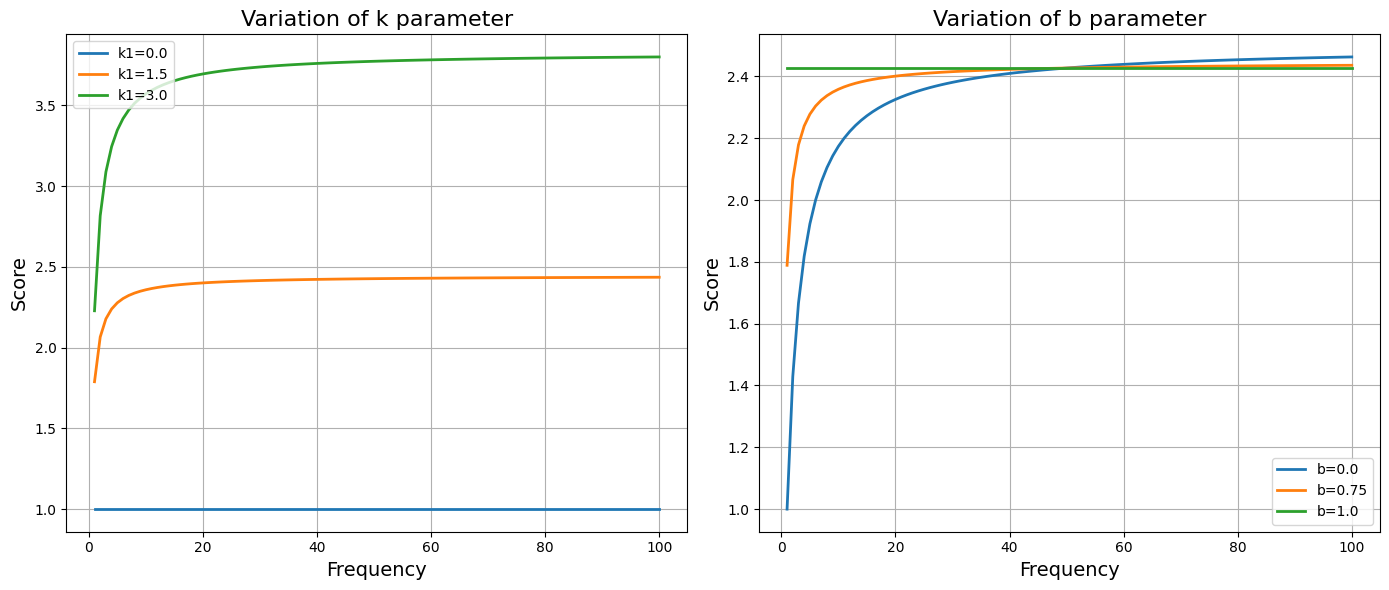

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate term frequencies
frequencies = np.arange(1, 101)

# Define the average document length
avg_dl = 50

# Different values for k and b parameters
k_values = [0., 1.5, 3.0]
b_values = [0., 0.75, 1.0]


fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Variation of k parameter
for k1 in k_values:
    bm25_scores = ((k1 + 1) * frequencies) / (k1 * (1 - 0.75 + 0.75 * frequencies / avg_dl) + frequencies)
    axs[0].plot(frequencies, bm25_scores, label=f'k1={k1}', linewidth=2)

axs[0].set_title('Variation of k parameter', fontsize=16)
axs[0].set_xlabel('Frequency', fontsize=14)
axs[0].set_ylabel('Score', fontsize=14)
axs[0].legend()
axs[0].grid(True)

# Variation of b parameter
for b in b_values:
    bm25_scores = ((1.5 + 1) * frequencies) / (1.5 * (1 - b + b * frequencies / avg_dl) + frequencies)
    axs[1].plot(frequencies, bm25_scores, label=f'b={b}', linewidth=2)

axs[1].set_title('Variation of b parameter', fontsize=16)
axs[1].set_xlabel('Frequency', fontsize=14)
axs[1].set_ylabel('Score', fontsize=14)
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig('b_and_k_values.jpg', format='jpeg')
plt.show()


BERT 모델의 문맥적 임베딩(contextual embedding) 능력을 시각화하기 위해 다의어 "bank"의 서로 다른 의미를 분석합니다. 10개의 문장을 준비하는데, "bank"가 금융 기관을 의미하는 경우와 강둑을 의미하는 경우를 각각 5개씩 번갈아 배치합니다. 각 문장에는 'money' 또는 'river' 레이블을 부여하여 실제 의미를 표시합니다.

`get_word_embedding()` 함수는 특정 문장에서 특정 단어의 임베딩을 추출합니다. `tokenizer(text, return_tensors='pt')`로 문장을 토큰화하고, `tokenizer.tokenize(text)`로 개별 토큰 리스트를 얻은 후 `word_idx = tokenized_text.index(word)`로 "bank"의 위치를 찾습니다. BERT 모델을 통과시킨 후 `outputs.last_hidden_state[0, word_idx, :]`로 해당 단어의 768차원 벡터를 추출하는데, 이것이 TF-IDF와 근본적으로 다른 점입니다. TF-IDF에서는 "bank"라는 단어가 문맥에 관계없이 항상 같은 벡터로 표현되지만, BERT는 주변 단어들을 고려하여 매번 다른 벡터를 생성합니다.

`bert-base-uncased` 모델을 로드하고 10개 문장 각각에서 "bank"의 임베딩을 추출하면 10개의 768차원 벡터를 얻게 됩니다. 이를 시각화하기 위해 t-SNE를 사용하여 768차원을 2차원으로 축소합니다. `perplexity=5`는 t-SNE가 각 점의 이웃을 고려하는 범위를 설정하는데, 데이터가 10개밖에 없어서 작은 값을 사용합니다.

산점도를 그릴 때 금융 의미는 파란색, 강둑 의미는 초록색으로 구분하고 `plt.annotate()`로 각 점에 전체 문장을 표시합니다. 만약 BERT가 문맥을 제대로 이해했다면, 같은 의미를 가진 "bank"들이 2차원 공간에서 서로 가까이 클러스터링되어 나타날 것입니다. 이는 BERT가 단순히 단어 자체가 아니라 문맥 속에서의 의미를 포착한다는 것을 시각적으로 증명합니다.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

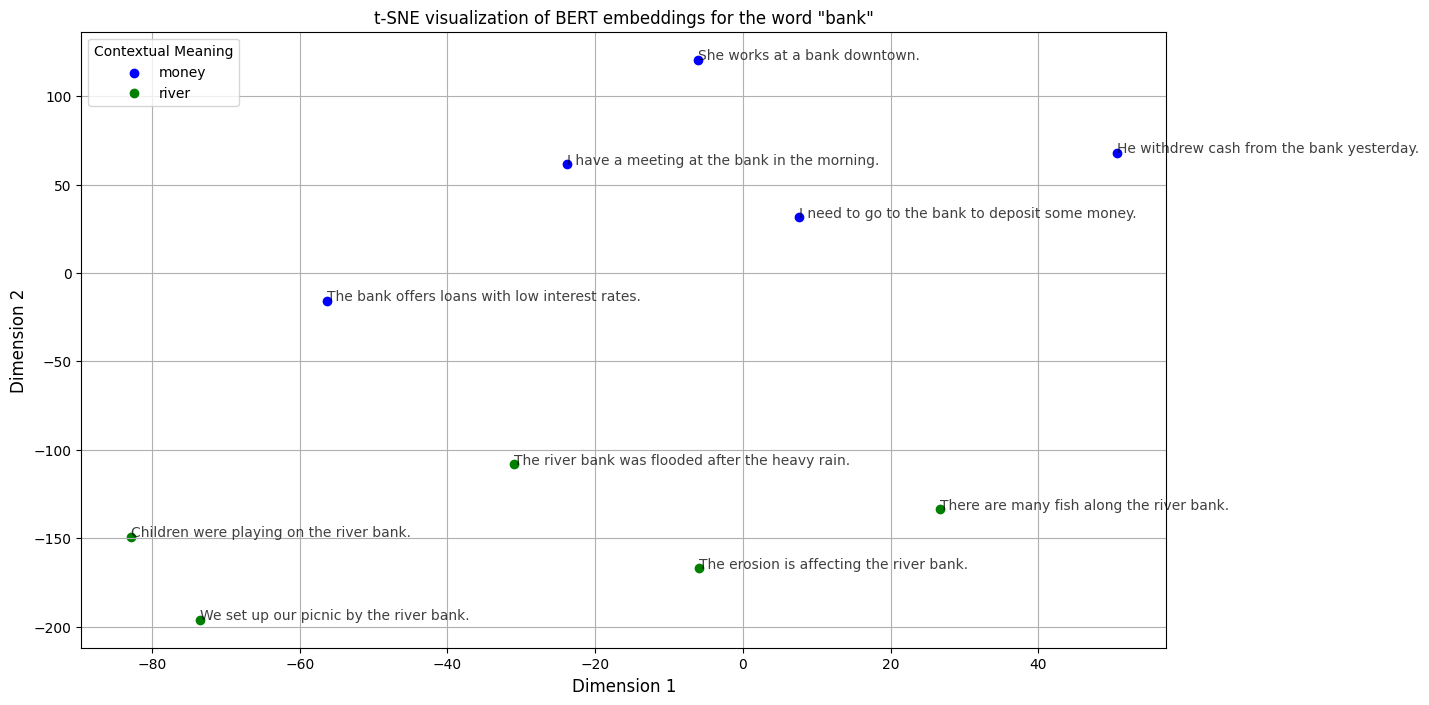

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

# List of sentences with the word "bank" having different meanings
sentences = [
    "I need to go to the bank to deposit some money.",
    "The river bank was flooded after the heavy rain.",
    "She works at a bank downtown.",
    "We set up our picnic by the river bank.",
    "He withdrew cash from the bank yesterday.",
    "There are many fish along the river bank.",
    "The bank offers loans with low interest rates.",
    "Children were playing on the river bank.",
    "I have a meeting at the bank in the morning.",
    "The erosion is affecting the river bank."
]

# Labels indicating the meaning of "bank" in each sentence
labels = ['money', 'river', 'money', 'river', 'money', 'river', 'money', 'river', 'money', 'river']


# Function to get embeddings for the word "bank" in each sentence
def get_word_embedding(text, word, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt')
    tokenized_text = tokenizer.tokenize(text)
    word_idx = tokenized_text.index(word)
    with torch.no_grad():
        outputs = model(**inputs)
    word_embedding = outputs.last_hidden_state[0, word_idx, :].numpy()
    return word_embedding

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Get embeddings for the word "bank" in all sentences
embeddings = np.array([get_word_embedding(sentence, "bank", model, tokenizer) for sentence in sentences])

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(14, 8))
colors = {'money': 'blue', 'river': 'green'}
for i, label in enumerate(labels ):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=colors[label], label=label if (labels + ['money', 'river']).index(label) == i else "")
    plt.annotate(sentences[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=10, alpha=0.75)

plt.title('t-SNE visualization of BERT embeddings for the word "bank"')
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.legend(title="Contextual Meaning", loc= 'upper left')
plt.grid(True)
plt.savefig('bank polysemi.jpg', format='jpeg')
plt.show()


이전 예제와 동일한 10개의 문장을 사용하지만, 이번에는 특정 단어가 아닌 문장 전체의 임베딩을 추출하는 방식으로 접근합니다. `get_cls_embedding()` 함수는 BERT의 [CLS] 토큰 임베딩을 반환하는데, 이는 문장 전체의 의미를 압축한 표현입니다. `outputs.last_hidden_state[:, 0, :]`에서 인덱스 0은 BERT가 모든 입력 시퀀스의 맨 앞에 추가하는 특수 토큰 [CLS]의 위치를 의미합니다.

BERT의 Transformer 구조는 self-attention 메커니즘을 통해 [CLS] 토큰이 문장의 모든 다른 토큰들과 상호작용하도록 설계되어 있습니다. 따라서 최종 레이어에서 [CLS] 토큰의 768차원 벡터는 문장 전체의 문맥 정보를 응축한 표현으로 작동합니다. 이전 예제에서는 "bank" 단어 하나의 임베딩만 추출했다면, 여기서는 "I need to go to the bank to deposit some money." 같은 전체 문장을 하나의 벡터로 인코딩합니다.

각 문장마다 `get_cls_embedding()`을 호출하여 10개의 768차원 벡터를 생성하고, 동일하게 t-SNE로 2차원 축소를 수행합니다. 시각화에서 `label_to_scatter` 딕셔너리를 사용해 범례 텍스트를 'Bank (Money)'와 'Bank (River)'로 더 명확하게 표시합니다. `if i == labels.index(label)`은 각 레이블이 처음 등장할 때만 범례에 추가되도록 하여 중복을 방지합니다.

이 방식은 문장 수준의 유사도를 측정할 때 유용합니다. 예를 들어 "I need to go to the bank to deposit some money."와 "He withdrew cash from the bank yesterday."는 둘 다 금융 문맥이므로 2차원 공간에서 가까이 위치하게 됩니다. RAG 시스템에서는 이런 문장 임베딩을 사용해 쿼리와 가장 유사한 문서 청크를 검색하는 bi-encoder 방식의 기초가 됩니다.

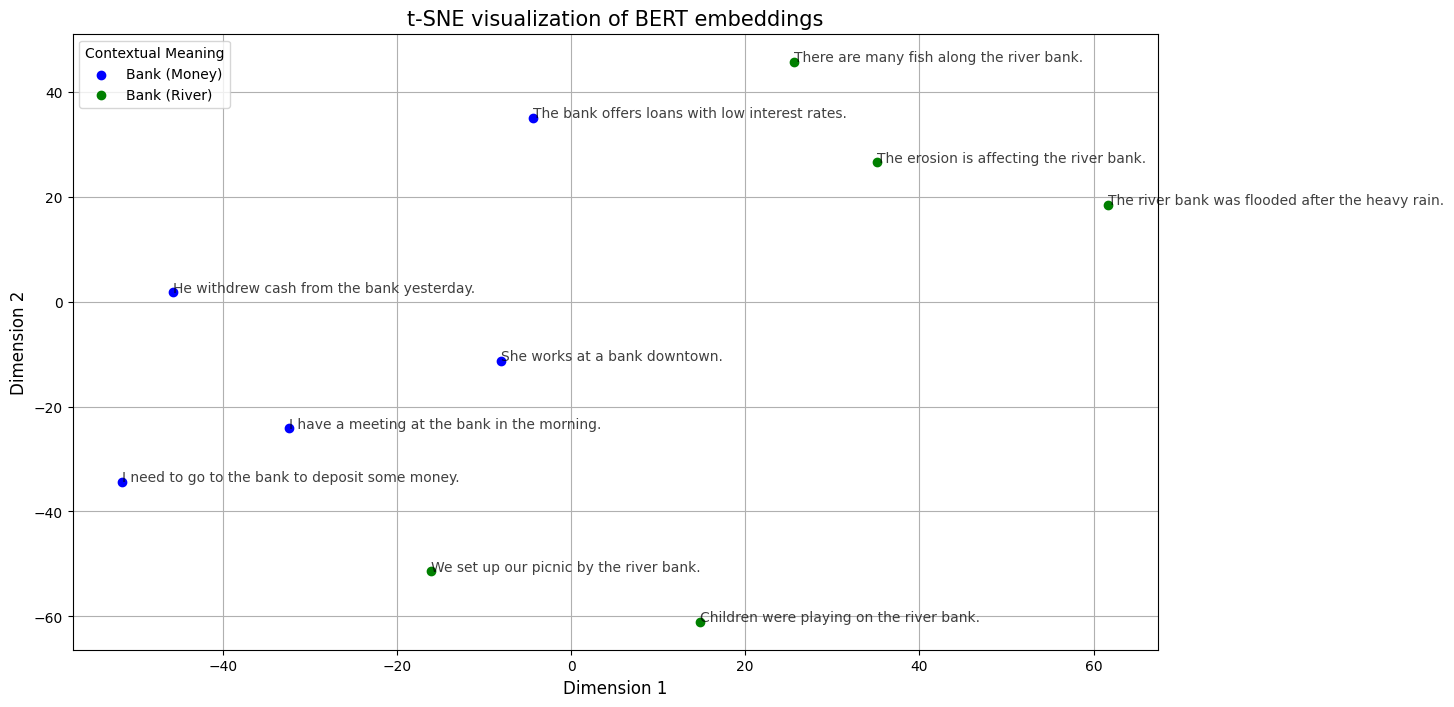

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertModel, BertTokenizer
import torch
import numpy as np

# List of sentences with the word "bank" having different meanings
sentences = [
    "I need to go to the bank to deposit some money.",
    "The river bank was flooded after the heavy rain.",
    "She works at a bank downtown.",
    "We set up our picnic by the river bank.",
    "He withdrew cash from the bank yesterday.",
    "There are many fish along the river bank.",
    "The bank offers loans with low interest rates.",
    "Children were playing on the river bank.",
    "I have a meeting at the bank in the morning.",
    "The erosion is affecting the river bank."
]

# Labels indicating the meaning of "bank" in each sentence
labels = ['money', 'river', 'money', 'river', 'money', 'river', 'money', 'river', 'money', 'river']

# Function to get CLS embeddings
def get_cls_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Get embeddings for all sentences
embeddings = np.array([get_cls_embedding(sentence, model, tokenizer) for sentence in sentences])

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)


plt.figure(figsize=(14, 8))
colors = {'money': 'blue', 'river': 'green'}
label_to_scatter = {'money': 'Bank (Money)', 'river': 'Bank (River)'}
for i, label in enumerate(labels):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=colors[label], label=label_to_scatter[label] if i == labels.index(label) else "")
    plt.annotate(sentences[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=10, alpha=0.75)

plt.title('t-SNE visualization of BERT embeddings', fontsize=15)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.legend(title="Contextual Meaning")
plt.grid(True)
plt.show()


동일한 10개 문장에 두 개의 쿼리를 추가하여 bi-encoder 방식의 검색을 시연합니다. 첫 번째 쿼리 "I opened a new savings account at the bank."는 금융 문맥이고, 두 번째 쿼리 "The fisherman stood by the river bank all day."는 강둑 문맥입니다. 이전과 동일한 `get_cls_embedding()` 함수로 10개 문장과 2개 쿼리를 각각 독립적으로 인코딩하여 12개의 768차원 벡터를 생성합니다.

`cosine_similarity(embeddings, new_embeddings)`는 10개 문서 벡터와 2개 쿼리 벡터 간의 모든 조합을 계산하여 10x2 행렬을 반환합니다. 각 셀은 -1에서 1 사이의 값으로, 1에 가까울수록 의미적으로 유사함을 나타냅니다. Bi-encoder 방식의 핵심은 쿼리와 문서를 별도로 인코딩한 후 단순 벡터 연산으로 유사도를 계산한다는 점인데, 이는 수백만 개의 문서를 사전에 인코딩해두고 빠르게 검색할 수 있게 합니다.

시각화를 위해 `sorted_indices`로 레이블 기준 정렬을 수행하여 'money' 관련 문장들이 상단에, 'river' 관련 문장들이 하단에 그룹화됩니다. `sns.heatmap()`으로 히트맵을 그리면 색상으로 유사도를 직관적으로 파악할 수 있습니다. `annot=True`는 각 셀에 실제 유사도 값을 표시하고, `fmt='.2f'`는 소수점 둘째 자리까지만 보여줍니다.

이상적인 결과라면 왼쪽 열(금융 쿼리)의 상단 5개 셀과 오른쪽 열(강둑 쿼리)의 하단 5개 셀에서 높은 유사도 값이 나타나야 합니다. 쿼리 텍스트에 `\n`을 삽입하여 x축 레이블이 두 줄로 표시되도록 해서 가독성을 높였습니다. 이 히트맵은 BERT가 문맥을 고려하여 같은 단어 "bank"를 포함하더라도 의미적 유사성을 올바르게 구분할 수 있음을 보여주며, RAG 시스템의 검색 단계에서 이런 의미 기반 매칭이 키워드 기반 검색보다 우수한 이유를 시각적으로 증명합니다.

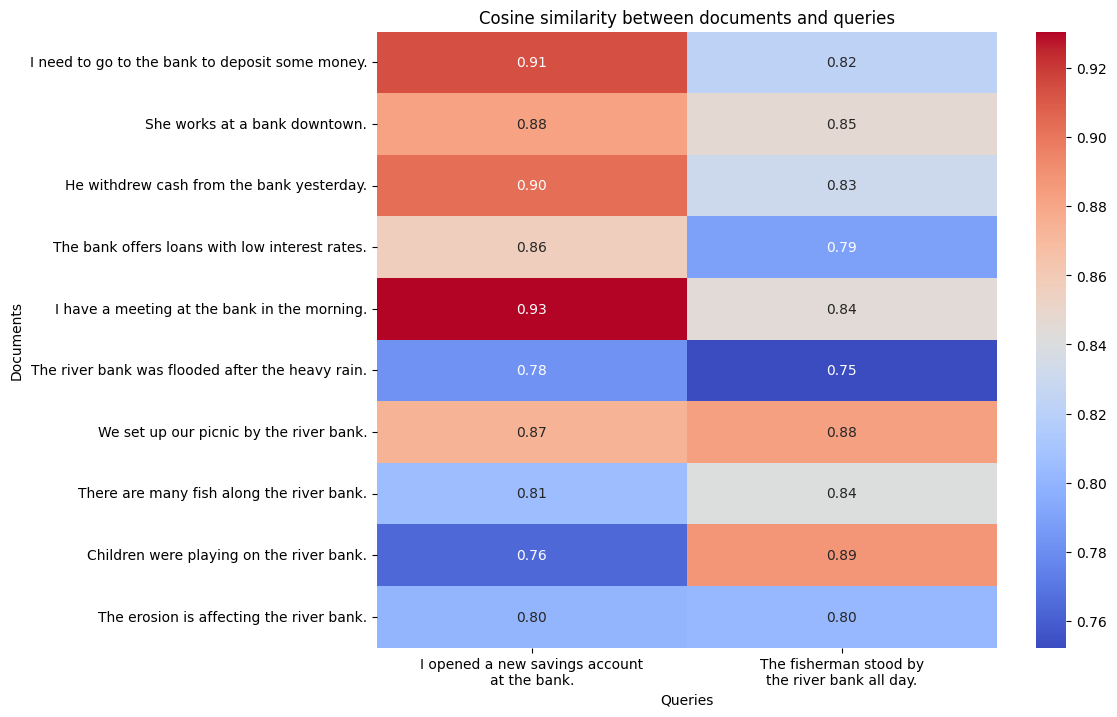

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# List of sentences with the word "bank" having different meanings
sentences = [
    "I need to go to the bank to deposit some money.",
    "The river bank was flooded after the heavy rain.",
    "She works at a bank downtown.",
    "We set up our picnic by the river bank.",
    "He withdrew cash from the bank yesterday.",
    "There are many fish along the river bank.",
    "The bank offers loans with low interest rates.",
    "Children were playing on the river bank.",
    "I have a meeting at the bank in the morning.",
    "The erosion is affecting the river bank."
]

# Labels indicating the meaning of "bank" in each sentence
labels = ['money', 'river', 'money', 'river', 'money', 'river', 'money', 'river', 'money', 'river']


queries = [
    "I opened a new savings account at the bank.",  # money
    "The fisherman stood by the river bank all day."  # river
]

# Function to get CLS embeddings
def get_cls_embedding(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Get embeddings for all sentences
embeddings = np.array([get_cls_embedding(sentence, model, tokenizer) for sentence in sentences])
new_embeddings = np.array([get_cls_embedding(sentence, model, tokenizer) for sentence in queries])

# Calculate cosine similarities
similarities = cosine_similarity(embeddings, new_embeddings)

# Reorder sentences and similarities based on labels
sorted_indices = sorted(range(len(labels)), key=lambda i: labels[i])
sorted_sentences = [sentences[i] for i in sorted_indices]
sorted_similarities = similarities[sorted_indices, :]

queries = [
    "I opened a new savings account\nat the bank.",  # money
    "The fisherman stood by\nthe river bank all day."  # river
]
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_similarities, annot=True, xticklabels=queries,
            yticklabels=sorted_sentences, cmap='coolwarm', fmt='.2f')
plt.title('Cosine similarity between documents and queries')
plt.xlabel('Queries')
plt.ylabel('Documents')
plt.savefig('bi-encoder.jpg', format='jpeg', bbox_inches='tight')
plt.show()


# Tokenization

## simple splitting no overlap

RAG 시스템에서 긴 문서를 처리하기 위한 텍스트 청킹(chunking) 기법을 시각화합니다. Langchain의 `TokenTextSplitter`를 사용하여 `chunk_size=80`으로 설정하면 각 청크가 최대 80개의 토큰을 포함하도록 분할됩니다. `chunk_overlap=0`은 청크 간 겹치는 부분이 없음을 의미하는데, 이는 가장 단순한 분할 방식입니다.

`color_text_chunks()` 함수는 분할된 청크들을 시각적으로 구분하기 위해 각기 다른 배경색을 적용합니다. `text_splitter.create_documents([text])`는 입력 텍스트를 Document 객체 리스트로 반환하고, `doc.page_content`로 실제 텍스트 내용에 접근합니다. 20가지 색상 팔레트를 준비하여 `colors[i % len(colors)]`로 순환하며 적용하므로 청크가 20개를 초과해도 색상이 반복됩니다.

셰익스피어의 햄릿 독백을 예제로 사용하는데, BERT 토크나이저가 이를 서브워드 단위로 분할합니다. 예를 들어 "Whether"는 ["whe", "##ther"]처럼 여러 토큰으로 나뉠 수 있습니다. 80토큰 제한으로 인해 긴 텍스트가 여러 청크로 분리되며, 각 청크는 다른 색상으로 표시되어 경계를 명확히 보여줍니다.

HTML 포맷으로 출력하기 위해 각 청크를 `<span>` 태그로 감싸고 `style="background-color:{color}"`로 배경색을 지정합니다. `<br><br>` 태그로 청크 사이에 여백을 추가하여 시각적 분리를 강화합니다. 이런 청킹 전략은 RAG에서 매우 중요한데, 너무 작으면 문맥이 부족하고 너무 크면 검색 정확도가 떨어지므로 적절한 chunk_size 선택이 성능에 직접적인 영향을 미칩니다. Overlap이 0이면 청크 경계에서 문장이 잘릴 수 있어 의미가 손상될 위험이 있습니다.

In [ ]:
from transformers import BertTokenizer
from IPython.display import HTML
from langchain.text_splitter import TokenTextSplitter

# Initialize the tokenizer and text splitter
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_splitter = TokenTextSplitter(
    chunk_size = 80,
    chunk_overlap = 0
)

# Function to color and display text chunks
def color_text_chunks(text, text_splitter):
    docs = text_splitter.create_documents([text])
    chunks = [doc.page_content for doc in docs]  # Access the text attribute

    colored_text = ""
    colors = ['#ff9999', '#99ff99', '#9999ff', '#ffff99', '#99ffff', '#ff99ff', '#cccccc',
              '#ff6666', '#66ff66', '#6666ff', '#ffff66', '#66ffff', '#ff66ff', '#ccccff',
              '#996699', '#669999', '#999966', '#669966', '#966696', '#696669']

    for i, chunk in enumerate(chunks):
        color = colors[i % len(colors)]
        chunk_html = f'<span style="background-color:{color}">{chunk}</span>'
        colored_text += chunk_html + '<br><br>'

    return HTML(colored_text)


text = '''To be or not to be, that is the question.
Whether tis nobler in the mind to suffer
The slings and arrows of outrageous fortune
Or to take arms against a sea of troubles,
And by opposing, end them. To die, to sleep
No more, and by a sleep to say we end,
The heartache and the thousand natural shocks
That flesh is heir to, tis a consummation
Devoutly to be wished.'''

color_text_chunks(text, text_splitter)


## simple splitting with overlap

이전 예제에 chunk_overlap 기능을 추가하여 청크 간 겹치는 영역을 시각화합니다. `chunk_size=80`, `chunk_overlap=20`으로 설정하면 각 청크는 80토큰이지만, 연속된 두 청크 사이에 20토큰이 중복됩니다. 이는 청크 경계에서 문맥이 끊기는 문제를 완화하는 중요한 기법입니다.

`color_text_chunks()` 함수는 이제 파라미터로 chunk_size와 overlap을 받아 내부에서 `TokenTextSplitter`를 생성합니다. 각 청크를 토큰 단위로 분해한 후, `chunk_length > overlap`인 경우 고유한 부분과 겹치는 부분을 구분하여 색상을 다르게 적용합니다. 고유 영역은 해당 청크의 순수 색상을, 겹치는 영역은 `blend_colors()`로 인접한 두 청크의 색상을 혼합한 중간 색상을 사용합니다.

`blend_colors()` 함수는 여러 16진수 색상 코드를 받아 RGB 각 채널의 평균을 계산합니다. 예를 들어 빨간색 `#ff9999`와 초록색 `#99ff99`를 혼합하면 황색 계열의 중간 색상이 생성됩니다. 비트 연산 `c >> 16`, `(c >> 8) & 0xff`, `c & 0xff`로 RGB 값을 추출하고, 평균을 구한 후 다시 16진수 문자열로 변환합니다.

토큰별로 색상을 적용하기 위해 `color_positions` 리스트를 구축하는데, 각 청크의 각 토큰이 어떤 색상을 가져야 하는지 미리 계산합니다. 중복 영역 처리를 위해 두 번째 루프에서 `color_positions[i] = [overlap_color] * overlap + color_positions[i][overlap:]`로 조정하여, 이전 청크와 겹치는 앞부분 20토큰은 혼합 색상으로 설정합니다.

최종적으로 각 토큰을 `<span>` 태그로 개별 포장하여 토큰 레벨의 세밀한 색상 제어가 가능합니다. 결과 HTML에서 동일한 텍스트가 두 청크에 모두 나타나는 겹침 영역은 혼합된 중간 색상으로 표시되어, overlap이 어떻게 작동하는지 직관적으로 이해할 수 있습니다. RAG에서 overlap=20은 청크 경계 근처의 정보가 양쪽 청크에 모두 포함되어 검색 누락을 방지하는 역할을 합니다.

In [ ]:
from transformers import BertTokenizer
from IPython.display import HTML
from langchain.text_splitter import TokenTextSplitter
from collections import defaultdict

# Initialize the tokenizer and text splitter
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to color and display text chunks
def color_text_chunks(text, chunk_size, overlap):
    text_splitter = TokenTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap
    )
    docs = text_splitter.create_documents([text])
    chunks = [doc.page_content for doc in docs]  # Access the text attribute

    # Define colors
    colors = ['#ff9999', '#99ff99', '#9999ff', '#ffff99', '#99ffff', '#ff99ff', '#cccccc',
              '#ff6666', '#66ff66', '#6666ff', '#ffff66', '#66ffff', '#ff66ff', '#ccccff',
              '#996699', '#669999', '#999966', '#669966', '#966696', '#696669']

    # Define color positions for each chunk
    color_positions = []
    for i in range(len(chunks)):
        chunk_tokens = tokenizer.tokenize(chunks[i])
        chunk_length = len(chunk_tokens)
        if chunk_length > overlap:
            unique_length = chunk_length - overlap
            chunk_colors = [colors[i % len(colors)]] * unique_length + \
                           [blend_colors([colors[i % len(colors)], colors[(i+1) % len(colors)]])] * overlap
        else:
            chunk_colors = [blend_colors([colors[i % len(colors)], colors[(i+1) % len(colors)]])] * chunk_length
        color_positions.append(chunk_colors)

    # Adjust colors for overlapping tokens in the next chunk
    for i in range(1, len(color_positions)):
        overlap_color = blend_colors([colors[(i-1) % len(colors)], colors[i % len(colors)]])
        color_positions[i] = [overlap_color] * overlap + color_positions[i][overlap:]

    # Generate colored HTML
    colored_text = ""
    for i, chunk in enumerate(chunks):
        tokens = tokenizer.tokenize(chunk)
        for j, token in enumerate(tokens):
            color = color_positions[i][j]
            token_html = f'<span style="background-color:{color}">{token}</span>'
            colored_text += token_html + ' '
        colored_text += '<br><br>'

    return HTML(colored_text)

def blend_colors(color_list):
    # Simple function to blend multiple colors
    r, g, b = 0, 0, 0
    for color in color_list:
        c = int(color[1:], 16)
        r += c >> 16
        g += (c >> 8) & 0xff
        b += c & 0xff
    n = len(color_list)
    r = min(r // n, 255)
    g = min(g // n, 255)
    b = min(b // n, 255)
    return f'#{r:02x}{g:02x}{b:02x}'

text = '''To be or not to be, that is the question.
Whether tis nobler in the mind to suffer
The slings and arrows of outrageous fortune
Or to take arms against a sea of troubles,
And by opposing, end them. To die, to sleep
No more, and by a sleep to say we end,
The heartache and the thousand natural shocks
That flesh is heir to, tis a consummation
Devoutly to be wished.'''

chunk_size = 80
overlap = 20

color_text_chunks(text, chunk_size, overlap)


## Character splitting on the new line

토큰 기반이 아닌 문자 기반 분할 방식으로 전환하여 `CharacterTextSplitter`를 사용합니다. `separator="\n"`은 줄바꿈 문자를 기준으로 텍스트를 먼저 분할하라는 의미이며, `chunk_size=256`은 이제 토큰 개수가 아닌 문자 개수를 나타냅니다. 이 방식은 텍스트의 자연스러운 구조를 보존하려는 접근법입니다.

`CharacterTextSplitter`는 지정된 구분자로 텍스트를 먼저 나눈 후, 각 조각이 chunk_size를 초과하지 않도록 조합합니다. 셰익스피어 텍스트에서 각 행이 줄바꿈으로 구분되어 있으므로, 분할기는 행 단위로 텍스트를 분리한 다음 256자 제한 내에서 여러 행을 하나의 청크로 묶습니다. 예를 들어 "To be or not to be, that is the question."이 60자라면, 다음 몇 행을 추가로 포함하여 256자에 가깝게 채웁니다.

토큰 기반 분할과의 핵심 차이는 의미 단위를 고려한다는 점입니다. 토큰 분할은 80번째 토큰에서 기계적으로 자르지만, 문자 기반 분할은 줄바꿈 같은 자연스러운 경계를 우선시합니다. 만약 다음 행을 추가하면 256자를 초과한다면, 그 행은 다음 청크로 넘어가서 문장이나 문단이 중간에 잘리는 것을 방지합니다.

`color_text_chunks()` 함수는 이전과 동일하지만, 이제 각 청크는 완전한 행들의 집합이 됩니다. 시각화 결과를 보면 청크 경계가 줄바꿈과 일치하여 더 자연스럽게 나뉩니다. 이 방식은 시나 코드처럼 줄 단위로 의미가 구분되는 텍스트에 특히 효과적이며, RAG 시스템에서 문서의 논리적 구조를 유지하면서 분할할 수 있어 검색된 청크가 더 의미있는 정보 단위를 포함하게 됩니다. separator를 `"\n\n"`으로 변경하면 문단 단위 분할도 가능합니다.

In [ ]:
from transformers import BertTokenizer
from IPython.display import HTML
from langchain.text_splitter import CharacterTextSplitter
# Initialize the tokenizer and text splitter
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 256,
    chunk_overlap = 0
)

# Function to color and display text chunks
def color_text_chunks(text, text_splitter):
    docs = text_splitter.create_documents([text])
    chunks = [doc.page_content for doc in docs]  # Access the text attribute

    colored_text = ""
    colors = ['#ff9999', '#99ff99', '#9999ff', '#ffff99', '#99ffff', '#ff99ff', '#cccccc',
              '#ff6666', '#66ff66', '#6666ff', '#ffff66', '#66ffff', '#ff66ff', '#ccccff',
              '#996699', '#669999', '#999966', '#669966', '#966696', '#696669']

    for i, chunk in enumerate(chunks):
        color = colors[i % len(colors)]
        chunk_html = f'<span style="background-color:{color}">{chunk}</span>'
        colored_text += chunk_html + '<br><br>'

    return HTML(colored_text)

# Example usage
text = '''To be or not to be, that is the question.
Whether tis nobler in the mind to suffer
The slings and arrows of outrageous fortune
Or to take arms against a sea of troubles,
And by opposing, end them. To die, to sleep
No more, and by a sleep to say we end,
The heartache and the thousand natural shocks
That flesh is heir to, tis a consummation
Devoutly to be wished.'''

color_text_chunks(text, text_splitter)


## Recursive character splitting

텍스트 분할 전략인 `RecursiveCharacterTextSplitter`를 도입합니다. `separators=["\n\n", "\n", " ", ""]`는 우선순위가 있는 구분자 리스트로, 분할기가 이 순서대로 시도합니다. 먼저 빈 줄(`\n\n`)로 문단을 분리하려 하고, 불가능하면 단일 줄바꿈(`\n`)으로, 그것도 안 되면 공백(` `)으로, 최후에는 문자 단위(`""`)로 강제 분할합니다.

이 재귀적 접근은 텍스트의 계층적 구조를 존중합니다. 예를 들어 256자 청크를 만들 때, 먼저 완전한 문단들을 조합하려 시도하고, 한 문단이 너무 크면 문장 단위로, 문장도 크면 단어 단위로, 단어조차 크면 문자 단위로 내려갑니다. 셰익스피어 텍스트는 문단 구분이 없으므로 두 번째 단계인 줄바꿈 기준 분할이 주로 작동하며, 필요시 공백으로 단어를 분리합니다.

`chunk_size=256`은 여전히 문자 개수 제한이고, `chunk_overlap=20`은 인접 청크 간 겹침을 설정합니다. 이전 overlap 시각화 로직을 재사용하여 각 토큰에 색상을 할당하는데, 겹치는 20토큰은 양쪽 청크의 혼합 색상으로 표시됩니다. `color_positions` 배열 구축 방식은 동일하지만, 이제 청크 자체가 더 의미 있는 경계에서 분할되어 결과가 개선됩니다.

실제 RAG 구현에서 `RecursiveCharacterTextSplitter`는 가장 널리 사용되는 기본 선택입니다. 기술 문서라면 `separators=["\n## ", "\n### ", "\n\n", "\n", " ", ""]`처럼 마크다운 헤더를 최우선으로 두어 섹션 단위 분할을 유도할 수 있습니다. 코드라면 함수나 클래스 경계를 구분자로 추가할 수 있습니다. 이 유연성 덕분에 다양한 문서 타입에 대해 문맥을 최대한 보존하면서 분할할 수 있으며, 검색 품질 향상으로 이어집니다.

In [ ]:
from transformers import BertTokenizer
from IPython.display import HTML
from langchain.text_splitter import TokenTextSplitter, RecursiveCharacterTextSplitter
from collections import defaultdict

# Initialize the tokenizer and text splitter
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to color and display text chunks
def color_text_chunks(text, chunk_size, overlap):
    text_splitter = RecursiveCharacterTextSplitter(
        separators = ["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=overlap
    )
    docs = text_splitter.create_documents([text])
    chunks = [doc.page_content for doc in docs]  # Access the text attribute

    # Define colors
    colors = ['#ff9999', '#99ff99', '#9999ff', '#ffff99', '#99ffff', '#ff99ff', '#cccccc',
              '#ff6666', '#66ff66', '#6666ff', '#ffff66', '#66ffff', '#ff66ff', '#ccccff',
              '#996699', '#669999', '#999966', '#669966', '#966696', '#696669']

    # Define color positions for each chunk
    color_positions = []
    for i in range(len(chunks)):
        chunk_tokens = tokenizer.tokenize(chunks[i])
        chunk_length = len(chunk_tokens)
        if chunk_length > overlap:
            unique_length = chunk_length - overlap
            chunk_colors = [colors[i % len(colors)]] * unique_length + \
                           [blend_colors([colors[i % len(colors)], colors[(i+1) % len(colors)]])] * overlap
        else:
            chunk_colors = [blend_colors([colors[i % len(colors)], colors[(i+1) % len(colors)]])] * chunk_length
        color_positions.append(chunk_colors)

    # Adjust colors for overlapping tokens in the next chunk
    for i in range(1, len(color_positions)):
        overlap_color = blend_colors([colors[(i-1) % len(colors)], colors[i % len(colors)]])
        color_positions[i] = [overlap_color] * overlap + color_positions[i][overlap:]

    # Generate colored HTML
    colored_text = ""
    for i, chunk in enumerate(chunks):
        tokens = tokenizer.tokenize(chunk)
        for j, token in enumerate(tokens):
            color = color_positions[i][j]
            token_html = f'<span style="background-color:{color}">{token}</span>'
            colored_text += token_html + ' '
        colored_text += '<br><br>'

    return HTML(colored_text)

def blend_colors(color_list):
    # Simple function to blend multiple colors
    r, g, b = 0, 0, 0
    for color in color_list:
        c = int(color[1:], 16)
        r += c >> 16
        g += (c >> 8) & 0xff
        b += c & 0xff
    n = len(color_list)
    r = min(r // n, 255)
    g = min(g // n, 255)
    b = min(b // n, 255)
    return f'#{r:02x}{g:02x}{b:02x}'

text = '''To be or not to be, that is the question.
Whether tis nobler in the mind to suffer
The slings and arrows of outrageous fortune
Or to take arms against a sea of troubles,
And by opposing, end them. To die, to sleep
No more, and by a sleep to say we end,
The heartache and the thousand natural shocks
That flesh is heir to, tis a consummation
Devoutly to be wished.'''

chunk_size = 256
overlap = 20

color_text_chunks(text, chunk_size, overlap)


## Markdown chunking

마크다운 형식 문서에 특화된 `MarkdownTextSplitter`를 사용하여 문서의 계층 구조를 인식하며 분할합니다. 이전 예제들과 달리 `text_splitter`를 함수 인자로 전달받도록 `color_text_chunks()` 시그니처를 수정하여 다양한 분할기를 유연하게 테스트할 수 있게 합니다. RAG 소개 문서를 마크다운 형식으로 작성했는데, `#`, `##`, `###` 같은 헤더와 `**` 볼드 문법, 번호 매긴 리스트 등을 포함합니다.

`MarkdownTextSplitter`는 마크다운 구조를 파싱하여 헤더 레벨을 인식합니다. `chunk_size=200` 문자 제한 내에서 헤더와 그 하위 내용을 함께 유지하려 시도하며, 섹션 전체가 200자를 초과하면 적절히 분할하되 헤더 구조를 가능한 보존합니다. 예를 들어 "## Introduction" 헤더와 그 아래 단락이 함께 하나의 청크로 묶일 수 있습니다.

`chunk_overlap=0`으로 설정했지만, 이전에 구현한 overlap 시각화 로직은 그대로 유지되어 있습니다. overlap이 0이므로 각 청크는 순수 색상만 가지며 혼합 색상 영역이 없습니다. `blend_colors()` 함수는 호출되지 않지만 코드 재사용성을 위해 남겨둡니다. 각 청크를 토큰 단위로 색칠하여 마크다운 분할 경계를 시각적으로 확인할 수 있습니다.

마크다운 특화 분할의 장점은 의미 단위 보존입니다. "### Retrieval Component"라는 소제목과 그 설명이 분리되지 않고, "## Advantages of RAG"와 그 하위 항목들이 논리적으로 묶입니다. 기술 문서, 블로그 포스트, GitHub README 같은 마크다운 소스를 RAG 시스템에 넣을 때 이 분할기를 사용하면 검색 결과가 완전한 정보 단위를 포함하여 LLM이 더 정확한 답변을 생성할 수 있습니다. 일반 `RecursiveCharacterTextSplitter`도 마크다운을 처리할 수 있지만, `MarkdownTextSplitter`는 마크다운 문법을 명시적으로 이해하여 더 정교한 분할을 수행합니다.

In [ ]:
from langchain.text_splitter import MarkdownTextSplitter
from transformers import BertTokenizer
from IPython.display import HTML
from langchain.text_splitter import TokenTextSplitter, RecursiveCharacterTextSplitter
from collections import defaultdict

# Initialize the tokenizer and text splitter
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to color and display text chunks
def color_text_chunks(text, chunk_size, overlap, text_splitter):

    docs = text_splitter.create_documents([text])
    chunks = [doc.page_content for doc in docs]  # Access the text attribute

    # Define colors
    colors = ['#ff9999', '#99ff99', '#9999ff', '#ffff99', '#99ffff', '#ff99ff', '#cccccc',
              '#ff6666', '#66ff66', '#6666ff', '#ffff66', '#66ffff', '#ff66ff', '#ccccff',
              '#996699', '#669999', '#999966', '#669966', '#966696', '#696669']

    # Define color positions for each chunk
    color_positions = []
    for i in range(len(chunks)):
        chunk_tokens = tokenizer.tokenize(chunks[i])
        chunk_length = len(chunk_tokens)
        if chunk_length > overlap:
            unique_length = chunk_length - overlap
            chunk_colors = [colors[i % len(colors)]] * unique_length + \
                           [blend_colors([colors[i % len(colors)], colors[(i+1) % len(colors)]])] * overlap
        else:
            chunk_colors = [blend_colors([colors[i % len(colors)], colors[(i+1) % len(colors)]])] * chunk_length
        color_positions.append(chunk_colors)

    # Adjust colors for overlapping tokens in the next chunk
    for i in range(1, len(color_positions)):
        overlap_color = blend_colors([colors[(i-1) % len(colors)], colors[i % len(colors)]])
        color_positions[i] = [overlap_color] * overlap + color_positions[i][overlap:]

    # Generate colored HTML
    colored_text = ""
    for i, chunk in enumerate(chunks):
        tokens = tokenizer.tokenize(chunk)
        for j, token in enumerate(tokens):
            color = color_positions[i][j]
            token_html = f'<span style="background-color:{color}">{token}</span>'
            colored_text += token_html + ' '
        colored_text += '<br><br>'

    return HTML(colored_text)

def blend_colors(color_list):
    # Simple function to blend multiple colors
    r, g, b = 0, 0, 0
    for color in color_list:
        c = int(color[1:], 16)
        r += c >> 16
        g += (c >> 8) & 0xff
        b += c & 0xff
    n = len(color_list)
    r = min(r // n, 255)
    g = min(g // n, 255)
    b = min(b // n, 255)
    return f'#{r:02x}{g:02x}{b:02x}'


text = '''
# Retrieval-Augmented Generation (RAG)

## Introduction

Retrieval-Augmented Generation (RAG) is a technique in natural language processing (NLP) that combines the strengths of retrieval-based methods and generation-based methods. It is designed to enhance the quality and accuracy of generated text by leveraging a large corpus of documents during the text generation process.

## How RAG Works

### Retrieval Component

The retrieval component is responsible for searching a large dataset or knowledge base to find relevant documents or passages that are related to the input query. This component typically uses advanced search algorithms and embeddings to identify the most pertinent information.

### Generation Component

The generation component takes the retrieved documents as additional context and generates a coherent and contextually accurate response. This is usually achieved using transformer-based models like BERT or GPT, which can process the input query along with the retrieved information to produce high-quality text.

## Advantages of RAG

1. **Enhanced Accuracy**: By using relevant external documents, RAG can generate more accurate and informed responses.
2. **Contextual Relevance**: The retrieval component ensures that the generated text is contextually relevant to the query.
3. **Scalability**: RAG can be scaled to work with vast datasets, making it suitable for applications requiring extensive knowledge bases.

## Applications of RAG

1. **Question Answering Systems**: RAG can be used to improve the performance of question answering systems by providing precise and detailed answers.
2. **Customer Support**: In customer support, RAG can assist in generating accurate responses to customer queries by referencing a large database of knowledge.
3. **Content Creation**: RAG can aid content creators by providing relevant information and generating high-quality content based on the retrieved data.

## Conclusion

Retrieval-Augmented Generation (RAG) represents a significant advancement in NLP by combining the best aspects of retrieval and generation methods. Its ability to utilize vast datasets for generating contextually accurate and high-quality text makes it a powerful tool for various applications.
'''

chunk_size = 200
overlap = 0

text_splitter = MarkdownTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=overlap
)

color_text_chunks(text, chunk_size, overlap, text_splitter)


## LaTex Chunker

학술 논문이나 기술 문서에서 흔히 사용하는 LaTeX 형식을 처리하기 위한 `LatexTextSplitter`를 적용합니다. 동일한 RAG 내용을 이번에는 LaTeX 문법으로 작성했는데, `\\section`, `\\subsection`, `\\subsubsection` 같은 계층적 섹션 명령어와 `\\begin{itemize}`, `\\item`, `\\textbf{}` 같은 환경 및 포맷팅 명령어를 포함합니다.

`LatexTextSplitter`는 LaTeX의 구조적 요소를 인식하여 분할합니다. `\\section`은 최상위 구분자로, `\\subsection`은 그 하위로 취급되며, `chunk_size=200` 제한 내에서 섹션 제목과 내용을 함께 유지하려 시도합니다. `\\begin{itemize}`와 `\\end{itemize}` 사이의 리스트 환경도 하나의 단위로 인식하여, 가능하면 전체 리스트를 분할하지 않고 보존합니다.

LaTeX 특유의 이스케이프 문자 처리가 중요합니다. `\\section`에서 백슬래시가 두 개인 것은 Python 문자열 이스케이프 때문이며, 실제로는 `\section` 하나를 의미합니다. 분할기는 이런 LaTeX 명령어를 구분자로 사용하여 논문의 논리적 구조를 따라 청크를 생성합니다. 예를 들어 "\\subsection{Advantages of RAG}"와 그 아래 `itemize` 환경 전체가 하나의 청크가 될 가능성이 높습니다.

동일한 `color_text_chunks()` 함수와 토큰 레벨 색상 시각화를 재사용하여 LaTeX 분할 결과를 확인합니다. 청크 경계가 `\\subsection` 같은 의미 있는 지점에서 발생하는지, 아니면 `\\item` 중간에서 잘리는지 볼 수 있습니다. 학술 논문, arXiv 프리프린트, 기술 매뉴얼처럼 LaTeX 소스를 RAG 시스템에 인덱싱할 때 이 분할기를 사용하면 수식, 정리, 증명 같은 구조가 청크 내에서 완전하게 유지되어 검색 품질이 크게 향상됩니다. 일반 텍스트 분할기로는 `\\begin`과 `\\end`가 분리되어 의미가 깨질 수 있지만, LaTeX 전용 분할기는 이런 매칭을 이해합니다.

In [ ]:
from langchain.text_splitter import LatexTextSplitter
text = '''
\\section{Retrieval-Augmented Generation (RAG)}

\\subsection{Introduction}

Retrieval-Augmented Generation (RAG) is a technique in natural language processing (NLP) that combines the strengths of retrieval-based methods and generation-based methods. It is designed to enhance the quality and accuracy of generated text by leveraging a large corpus of documents during the text generation process.

\\subsection{How RAG Works}

\\subsubsection{Retrieval Component}

The retrieval component is responsible for searching a large dataset or knowledge base to find relevant documents or passages that are related to the input query. This component typically uses advanced search algorithms and embeddings to identify the most pertinent information.

\\subsubsection{Generation Component}

The generation component takes the retrieved documents as additional context and generates a coherent and contextually accurate response. This is usually achieved using transformer-based models like BERT or GPT, which can process the input query along with the retrieved information to produce high-quality text.

\\subsection{Advantages of RAG}

\\begin{itemize}
    \\item \\textbf{Enhanced Accuracy}: By using relevant external documents, RAG can generate more accurate and informed responses.
    \\item \\textbf{Contextual Relevance}: The retrieval component ensures that the generated text is contextually relevant to the query.
    \\item \\textbf{Scalability}: RAG can be scaled to work with vast datasets, making it suitable for applications requiring extensive knowledge bases.
\\end{itemize}

\\subsection{Applications of RAG}

\\begin{itemize}
    \\item \\textbf{Question Answering Systems}: RAG can be used to improve the performance of question answering systems by providing precise and detailed answers.
    \\item \\textbf{Customer Support}: In customer support, RAG can assist in generating accurate responses to customer queries by referencing a large database of knowledge.
    \\item \\textbf{Content Creation}: RAG can aid content creators by providing relevant information and generating high-quality content based on the retrieved data.
\\end{itemize}

\\subsection{Conclusion}

Retrieval-Augmented Generation (RAG) represents a significant advancement in NLP by combining the best aspects of retrieval and generation methods. Its ability to utilize vast datasets for generating contextually accurate and high-quality text makes it a powerful tool for various applications.
'''

chunk_size = 200
overlap = 0

text_splitter = LatexTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=overlap
)

color_text_chunks(text, chunk_size, overlap, text_splitter)

## HTML splitter

웹 페이지나 HTML 문서를 RAG 시스템에 통합하기 위한 `HTMLHeaderTextSplitter`를 사용합니다. `color_text_chunks()` 함수를 수정하여 `create_documents()` 대신 `split_text()`를 호출하는데, 이는 HTMLHeaderTextSplitter의 API가 약간 다르기 때문입니다. 완전한 HTML 문서를 작성했는데 DOCTYPE 선언, head 섹션, body 태그를 모두 포함하며, RAG 내용은 h1, h2, h3 헤더 태그로 구조화되어 있습니다.

`headers_to_split_on = [("h1", "Header 1"), ("h2", "Header 2"), ("h3", "Header 3")]`은 분할 기준이 될 HTML 헤더 태그들을 지정합니다. 첫 번째 요소는 실제 태그명이고, 두 번째는 메타데이터에 저장될 레이블입니다. 분할기는 이 헤더들을 기준으로 HTML을 파싱하여 각 섹션을 별도 청크로 분리하며, 헤더 계층 구조를 인식하여 h2가 h1의 하위임을 이해합니다.

HTMLHeaderTextSplitter는 HTML 태그를 제거하고 순수 텍스트만 추출하면서도 문서 구조는 보존합니다. 예를 들어 `<h2>Introduction</h2><p>Retrieval-Augmented Generation...</p>`는 "Introduction" 헤더와 그 아래 단락이 하나의 청크로 묶입니다. `<strong>` 같은 포맷팅 태그 안의 텍스트는 추출되지만 태그 자체는 사라지며, `<ul><li>` 리스트도 평문으로 변환됩니다.

웹 스크래핑이나 문서 변환 파이프라인에서 이 분할기는 매우 유용합니다. 블로그 포스트, 제품 문서, 위키 페이지를 크롤링할 때 원본 HTML의 의미 구조를 활용하여 지능적으로 분할할 수 있습니다. `<h2>` 태그가 새로운 주제의 시작을 의미한다면, 분할기는 자동으로 그 지점에서 청크를 나눕니다. BeautifulSoup 같은 라이브러리로 HTML을 파싱한 후 평문으로 변환하는 것보다, 이 방식이 구조 정보를 더 잘 보존하여 검색 품질을 향상시킵니다. 메타데이터에 헤더 정보가 포함되어 청크가 어느 섹션에서 왔는지 추적할 수도 있습니다.

In [ ]:
from langchain_text_splitters import HTMLHeaderTextSplitter

def color_text_chunks(text, chunk_size, overlap, text_splitter):
    # modified for HTMLHeaderTextSplitter
    docs = text_splitter.split_text(text)
    chunks = [doc.page_content for doc in docs]  # Access the text attribute

    # Define colors
    colors = ['#ff9999', '#99ff99', '#9999ff', '#ffff99', '#99ffff', '#ff99ff', '#cccccc',
              '#ff6666', '#66ff66', '#6666ff', '#ffff66', '#66ffff', '#ff66ff', '#ccccff',
              '#996699', '#669999', '#999966', '#669966', '#966696', '#696669']

    # Define color positions for each chunk
    color_positions = []
    for i in range(len(chunks)):
        chunk_tokens = tokenizer.tokenize(chunks[i])
        chunk_length = len(chunk_tokens)
        if chunk_length > overlap:
            unique_length = chunk_length - overlap
            chunk_colors = [colors[i % len(colors)]] * unique_length + \
                           [blend_colors([colors[i % len(colors)], colors[(i+1) % len(colors)]])] * overlap
        else:
            chunk_colors = [blend_colors([colors[i % len(colors)], colors[(i+1) % len(colors)]])] * chunk_length
        color_positions.append(chunk_colors)

    # Adjust colors for overlapping tokens in the next chunk
    for i in range(1, len(color_positions)):
        overlap_color = blend_colors([colors[(i-1) % len(colors)], colors[i % len(colors)]])
        color_positions[i] = [overlap_color] * overlap + color_positions[i][overlap:]

    # Generate colored HTML
    colored_text = ""
    for i, chunk in enumerate(chunks):
        tokens = tokenizer.tokenize(chunk)
        for j, token in enumerate(tokens):
            color = color_positions[i][j]
            token_html = f'<span style="background-color:{color}">{token}</span>'
            colored_text += token_html + ' '
        colored_text += '<br><br>'

    return HTML(colored_text)


text = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Retrieval-Augmented Generation (RAG)</title>
</head>
<body>
    <h1>Retrieval-Augmented Generation (RAG)</h1>

    <h2>Introduction</h2>
    <p>Retrieval-Augmented Generation (RAG) is a technique in natural language processing (NLP) that combines the strengths of retrieval-based methods and generation-based methods. It is designed to enhance the quality and accuracy of generated text by leveraging a large corpus of documents during the text generation process.</p>

    <h2>How RAG Works</h2>

    <h3>Retrieval Component</h3>
    <p>The retrieval component is responsible for searching a large dataset or knowledge base to find relevant documents or passages that are related to the input query. This component typically uses advanced search algorithms and embeddings to identify the most pertinent information.</p>

    <h3>Generation Component</h3>
    <p>The generation component takes the retrieved documents as additional context and generates a coherent and contextually accurate response. This is usually achieved using transformer-based models like BERT or GPT, which can process the input query along with the retrieved information to produce high-quality text.</p>

    <h2>Advantages of RAG</h2>
    <ul>
        <li><strong>Enhanced Accuracy</strong>: By using relevant external documents, RAG can generate more accurate and informed responses.</li>
        <li><strong>Contextual Relevance</strong>: The retrieval component ensures that the generated text is contextually relevant to the query.</li>
        <li><strong>Scalability</strong>: RAG can be scaled to work with vast datasets, making it suitable for applications requiring extensive knowledge bases.</li>
    </ul>

    <h2>Applications of RAG</h2>
    <ul>
        <li><strong>Question Answering Systems</strong>: RAG can be used to improve the performance of question answering systems by providing precise and detailed answers.</li>
        <li><strong>Customer Support</strong>: In customer support, RAG can assist in generating accurate responses to customer queries by referencing a large database of knowledge.</li>
        <li><strong>Content Creation</strong>: RAG can aid content creators by providing relevant information and generating high-quality content based on the retrieved data.</li>
    </ul>

    <h2>Conclusion</h2>
    <p>Retrieval-Augmented Generation (RAG) represents a significant advancement in NLP by combining the best aspects of retrieval and generation methods. Its ability to utilize vast datasets for generating contextually accurate and high-quality text makes it a powerful tool for various applications.</p>
</body>
</html>
'''


headers_to_split_on = [
    ("h1", "Header 1"),
    ("h2", "Header 2"),
    ("h3", "Header 3"),
]

text_splitter = HTMLHeaderTextSplitter(headers_to_split_on)

color_text_chunks(text, chunk_size, overlap, text_splitter)

## Proposition chunking

지금까지와는 완전히 다른 접근인 명제 기반 청킹(proposition chunking)을 시연합니다. `chentong00/propositionizer-wiki-flan-t5-large` 모델은 위키피디아 스타일의 텍스트를 원자적 사실(atomic facts) 리스트로 분해하도록 훈련된 특수 모델입니다. GPU가 있으면 cuda를 사용하고 없으면 CPU로 폴백하여 `AutoModelForSeq2SeqLM`을 로드합니다.

피사의 사탑에 관한 짧은 단락을 예제로 사용하는데, 복원 작업 전후의 기울기 각도와 수평 변위를 언급하는 복합 문장입니다. `input_text`를 "Title: ... Section: ... Content: ..." 형식으로 구조화하는데, 이는 모델이 학습 시 기대하는 입력 포맷입니다. Section은 비워두었지만, 위키피디아처럼 "History" 같은 섹션명을 넣을 수도 있습니다.

`model.generate()`로 시퀀스-투-시퀀스 생성을 수행하며, `max_new_tokens=512`로 충분한 길이를 허용합니다. 모델의 출력은 JSON 배열 문자열로, 각 요소가 하나의 독립적인 명제입니다. 예를 들어 원본 문장에서 "1990년과 2001년 사이에 복원 작업이 수행되었다", "복원 전 기울기는 5.5도였다", "현재 기울기는 3.99도다", "꼭대기는 중심에서 수평으로 3.9미터 변위되었다" 같은 별도의 사실들로 분해됩니다.

`json.loads()`로 출력을 파싱하여 Python 리스트를 얻고, 실패하면 빈 리스트를 반환합니다. `json.dumps(prop_list, indent=2)`로 보기 좋게 출력합니다. 이 접근의 핵심 장점은 각 명제가 자체적으로 완결된 정보 단위라는 점입니다. 전통적 청킹에서는 "the tower now leans"만 포함된 청크가 문맥 없이 의미가 불분명하지만, 명제 청킹은 "The Leaning Tower of Pisa now leans at about 3.99 degrees" 같은 완전한 문장을 생성합니다. 이는 검색 정밀도를 높이고 LLM이 더 정확한 답변을 생성하도록 돕지만, 추가 모델 추론이 필요하여 계산 비용이 증가하는 트레이드오프가 있습니다.

In [ ]:
# from the original article: https://github.com/chentong0/factoid-wiki
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import json

model_name = "chentong00/propositionizer-wiki-flan-t5-large"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

title = "Leaning Tower of Pisa"
section = ""
content = "Prior to restoration work performed between 1990 and 2001, Leaning Tower of Pisa leaned at an angle of 5.5 degrees, but the tower now leans at about 3.99 degrees. This means the top of the tower is displaced horizontally 3.9 meters (12 ft 10 in) from the center."

input_text = f"Title: {title}. Section: {section}. Content: {content}"

input_ids = tokenizer(input_text, return_tensors="pt").input_ids
outputs = model.generate(input_ids.to(device), max_new_tokens=512).cpu()

output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
try:
    prop_list = json.loads(output_text)
except:
    prop_list = []
    print("[ERROR] Failed to parse output text as JSON.")
print(json.dumps(prop_list, indent=2))

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

[
  "Prior to restoration work performed between 1990 and 2001, Leaning Tower of Pisa leaned at an angle of 5.5 degrees.",
  "Leaning Tower of Pisa now leans at about 3.99 degrees.",
  "The top of Leaning Tower of Pisa is displaced horizontally 3.9 meters (12 ft 10 in) from the center."
]


# Quantization

벡터 임베딩의 메모리 효율성을 높이기 위한 양자화(quantization) 기법을 시연합니다. 익숙한 "bank" 문장 10개를 `mixedbread-ai/mxbai-embed-large-v1` 모델로 인코딩하는데, 이는 고품질 임베딩을 생성하는 최신 sentence transformer입니다. `model.encode(sentences)`는 각 문장을 고차원 부동소수점 벡터로 변환하며, 기본적으로 float32 정밀도를 사용합니다.

첫 번째 양자화는 이진(binary) 방식입니다. `quantize_embeddings(embeddings, precision="binary")`는 각 차원의 값을 단순히 양수면 1, 음수면 0으로 변환합니다. 원래 32비트 부동소수점 수가 1비트로 압축되어 32배 메모리 절감이 이론적으로 가능합니다. 정보 손실이 크지만 놀랍게도 많은 검색 작업에서 여전히 합리적인 성능을 유지합니다.

두 번째는 int8 양자화인데, 더 정교한 접근입니다. `load_dataset("nq_open", split="train[:1000]")`로 Natural Questions 데이터셋에서 1000개 질문을 가져와 calibration_embeddings를 생성합니다. 이 보정 데이터는 임베딩 값의 분포를 분석하여 최적의 스케일링 팩터를 결정하는데 사용됩니다. `quantize_embeddings()`는 각 차원을 -128에서 127 사이의 정수로 매핑하여 32비트를 8비트로 압축합니다. 이는 4배 압축률을 제공하며 이진 양자화보다 훨씬 정밀합니다.

`.nbytes` 속성으로 각 임베딩 배열의 실제 메모리 사용량을 바이트 단위로 측정하고, `embeddings_nbytes / binary_embeddings_nbytes`로 압축 비율을 계산합니다. 막대 그래프로 세 가지 방식의 크기를 비교하며, `plt.text()`로 각 압축 버전 위에 "32.00x", "4.00x" 같은 압축률을 표시합니다. 이 시각화는 수백만 개의 문서를 임베딩할 때 양자화가 얼마나 큰 메모리 절감을 가져오는지 명확히 보여주며, 대규모 RAG 시스템에서 int8 양자화가 성능과 효율성의 좋은 균형점임을 시사합니다.

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

nq_open/train-00000-of-00001.parquet:   0%|          | 0.00/4.46M [00:00<?, ?B/s]

nq_open/validation-00000-of-00001.parque(…):   0%|          | 0.00/214k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87925 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3610 [00:00<?, ? examples/s]

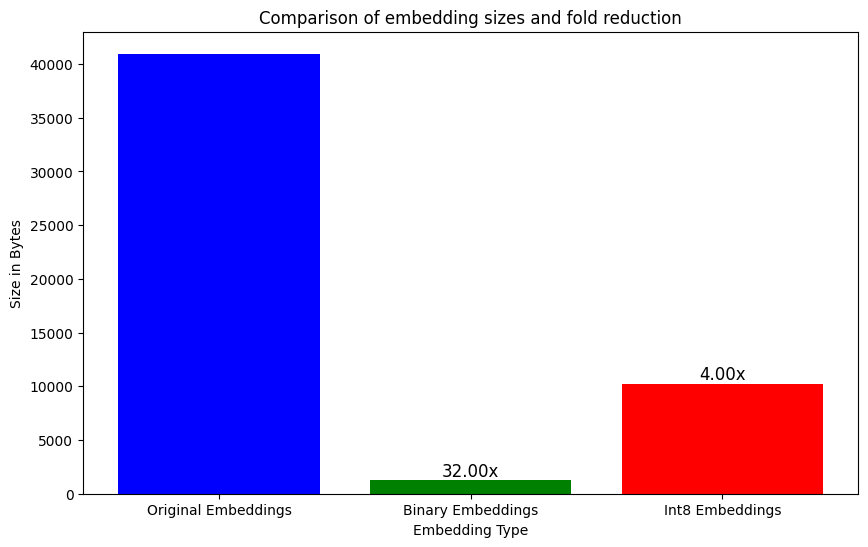

In [ ]:
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sentence_transformers.quantization import quantize_embeddings
from datasets import load_dataset


sentences = [
    "I need to go to the bank to deposit some money.",
    "The river bank was flooded after the heavy rain.",
    "She works at a bank downtown.",
    "We set up our picnic by the river bank.",
    "He withdrew cash from the bank yesterday.",
    "There are many fish along the river bank.",
    "The bank offers loans with low interest rates.",
    "Children were playing on the river bank.",
    "I have a meeting at the bank in the morning.",
    "The erosion is affecting the river bank."
]

# Load an embedding model
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

# Encode the sentences without quantization
embeddings = model.encode(sentences)

# Apply binary quantization
binary_embeddings = quantize_embeddings(embeddings, precision="binary")

# Prepare an example calibration dataset
corpus = load_dataset("nq_open", split="train[:1000]")["question"]
calibration_embeddings = model.encode(corpus)

# Apply int8 quantization
int8_embeddings = quantize_embeddings(
    embeddings,
    precision="int8",
    calibration_embeddings=calibration_embeddings,
)

# Collect nbytes information and fold reduction
embeddings_nbytes = embeddings.nbytes
binary_embeddings_nbytes = binary_embeddings.nbytes
int8_embeddings_nbytes = int8_embeddings.nbytes


binary_fold_reduction = embeddings_nbytes / binary_embeddings_nbytes
int8_fold_reduction = embeddings_nbytes / int8_embeddings_nbytes

# Plot the nbytes and fold reduction
labels = ['Original Embeddings', 'Binary Embeddings', 'Int8 Embeddings']
nbytes_values = [embeddings_nbytes, binary_embeddings_nbytes, int8_embeddings_nbytes]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, nbytes_values, color=['blue', 'green', 'red'])

plt.text(1, binary_embeddings_nbytes, f'{binary_fold_reduction:.2f}x', ha='center', va='bottom', fontsize=12)
plt.text(2, int8_embeddings_nbytes, f'{int8_fold_reduction:.2f}x', ha='center', va='bottom', fontsize=12)

plt.xlabel('Embedding Type')
plt.ylabel('Size in Bytes')
plt.title('Comparison of embedding sizes and fold reduction')
plt.savefig('vector quantization.jpg', format='jpeg', bbox_inches='tight')
plt.show()


마트료시카(Matryoshka) 임베딩 기법을 일반 모델과 비교합니다. 두 개의 MPNet 기반 모델을 로드하는데, 하나는 Matryoshka 방식으로 학습된 버전이고 다른 하나는 일반 모델입니다. STS Benchmark 데이터셋을 사용하여 평가하는데, 이는 문장 쌍의 의미적 유사도를 0-5 척도로 레이블한 것으로 `/5.0`으로 정규화하여 0-1 범위로 변환합니다.

핵심 아이디어는 768차원 임베딩을 다양한 크기로 잘라내어(truncate) 성능을 측정하는 것입니다. `dimensions = [768, 512, 256, 128, 64, 32, 16, 8]`로 8단계 축소를 시도하며, 각 차원에서 `SentenceTransformer(mod_name, truncate_dim=dim)`으로 모델을 재로드합니다. `truncate_dim`은 임베딩의 앞 dim개 차원만 사용하도록 지시하는데, 나머지는 버려집니다.

`EmbeddingSimilarityEvaluator`는 문장 쌍들을 인코딩하고 코사인 유사도를 계산한 후, 예측된 유사도와 실제 레이블 간의 Spearman 상관계수를 반환합니다. 일반 모델의 경우 768차원에서 최고 성능을 보이고, 차원을 줄일수록 성능이 급격히 떨어집니다. 이는 뒷부분 차원들이 중요한 정보를 담고 있는데 무작위로 잘라내면 손실되기 때문입니다.

Matryoshka 모델은 학습 시 특별한 손실 함수를 사용하여 앞부분 차원에 가장 중요한 정보를 배치하고, 뒷부분은 점진적으로 세밀한 정보를 추가하도록 훈련됩니다. 마치 러시아 인형처럼 큰 임베딩 안에 작은 임베딩이 내포된 구조입니다. 그래프를 보면 Matryoshka 모델은 128차원이나 64차원으로 줄여도 성능 저하가 완만하게 나타납니다.

RAG 시스템에서 빠른 후보 검색 단계에서는 64차원만 사용하여 속도를 높이고, 재순위화 단계에서는 전체 768차원을 사용하여 정밀도를 높일 수 있습니다. 또는 모바일 기기에서는 작은 차원, 서버에서는 큰 차원을 사용하는 등 리소스에 따라 적응할 수 있습니다. 그래프의 x축이 역순인 것처럼 보이지만 실제로는 왼쪽이 큰 차원(768)이고 오른쪽이 작은 차원(8)으로, 차원 감소에 따른 성능 변화를 보여줍니다.

modules.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

train.jsonl.gz:   0%|          | 0.00/278k [00:00<?, ?B/s]

validation.jsonl.gz:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

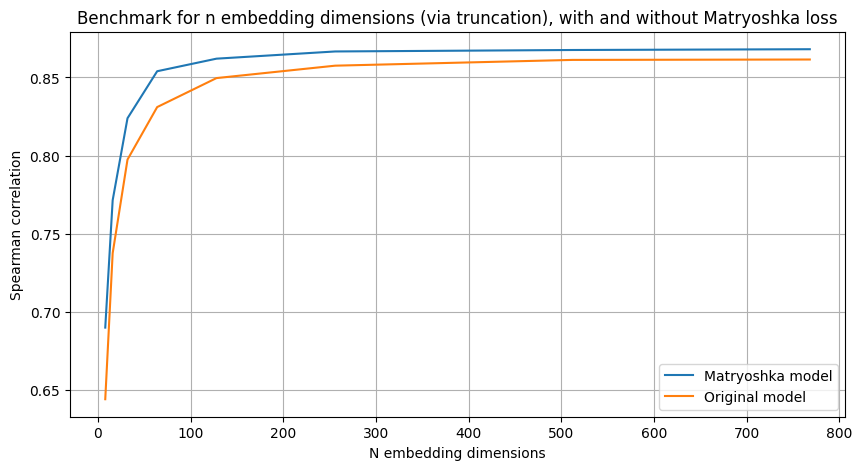

In [ ]:
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import numpy as np
from sentence_transformers import util, SentenceTransformer, evaluation
import matplotlib.pyplot as plt
from sentence_transformers.evaluation import (
    EmbeddingSimilarityEvaluator,
    SimilarityFunction,
)

# Load the models
model_names = ["tomaarsen/mpnet-base-nli-matryoshka", "tomaarsen/mpnet-base-nli"]
model_labels = ["Matryoshka model", "Original model"]
models = [SentenceTransformer(name) for name in model_names]

# Load the dataset
stsb_test = load_dataset("mteb/stsbenchmark-sts", split="test")

# Extract sentences and scores
sentences1 = stsb_test["sentence1"]
sentences2 = stsb_test["sentence2"]
scores = [score / 5.0 for score in stsb_test["score"]]

# Define dimensions to truncate to
dimensions = [768, 512, 256, 128, 64, 32, 16, 8]
results = {name: [] for name in model_names}

for mod_name in model_names:
    for dim in dimensions:
        # Truncate embeddings
        model = SentenceTransformer(mod_name, truncate_dim=dim)

        # Evaluate similarity
        evaluator = evaluation.EmbeddingSimilarityEvaluator(
            sentences1, sentences2, scores, main_similarity=SimilarityFunction.COSINE, name="sts-test"
        )
        score = evaluator(model)
        results[mod_name].append(score['sts-test_spearman_cosine'])

plt.figure(figsize=(10, 5))

for name, label in zip(model_names, model_labels):
    plt.plot(dimensions, results[name], label=label)

plt.xlabel("N embedding dimensions")
plt.ylabel("Spearman correlation")
plt.title("Benchmark for n embedding dimensions (via truncation), with and without Matryoshka loss")
plt.legend()
plt.grid(True)
plt.savefig('vector_matryoshka.jpg', format='jpeg', bbox_inches='tight')
plt.show()


# Evaluation

RAG 시스템의 검색 성능을 평가하기 위한 Precision-Recall 커브를 생성합니다. 상위 20개 검색 결과를 시뮬레이션하는데, 각 결과는 'R'(Relevant, 관련 있음) 또는 'NR'(Not Relevant, 관련 없음)로 레이블됩니다. 예제에서는 총 9개가 관련 있고 11개가 관련 없는 것으로 설정했습니다.

`df['binary_label'] = df['Label'].map({'R': 1, 'NR': 0})`로 문자 레이블을 이진 값으로 변환합니다. `df['score'] = -df['Rank']`는 순위를 점수로 변환하는데, 음수를 사용하여 1위가 -1, 2위가 -2가 되도록 합니다. 이는 sklearn의 `precision_recall_curve()`가 높은 점수를 양성으로 간주하므로, 낮은 순위(좋은 결과)가 높은 점수를 가지도록 하기 위함입니다.

`precision_recall_curve()`는 다양한 임계값에서 precision과 recall을 계산합니다. Precision은 검색된 결과 중 실제 관련 문서의 비율이고, Recall은 전체 관련 문서 중 검색된 비율입니다. 예를 들어 상위 5개를 선택했는데 4개가 관련 있다면 precision은 0.8이고, 전체 관련 문서 9개 중 4개를 찾았으므로 recall은 0.44입니다.

`auc(recall, precision)`는 Precision-Recall 커브 아래 면적을 계산하는데, 이는 전체적인 검색 품질을 하나의 숫자로 요약합니다. 1.0에 가까울수록 좋으며, 관련 문서들이 상위에 밀집되어 있을수록 높은 값이 나옵니다. 커브를 그릴 때 `label=f'PR curve (area = {pr_auc:.2f})'`로 AUC 값을 범례에 포함시켜 한눈에 성능을 파악할 수 있게 합니다.

RAG 시스템에서는 이 메트릭으로 다양한 임베딩 모델, 청킹 전략, 재순위화 기법을 비교할 수 있습니다. 이상적인 검색 시스템은 관련 문서들이 모두 상위에 나타나 오른쪽 위로 치우친 커브를 보입니다. 반대로 랜덤 검색은 대각선에 가까운 커브를 보이며 AUC가 낮습니다.

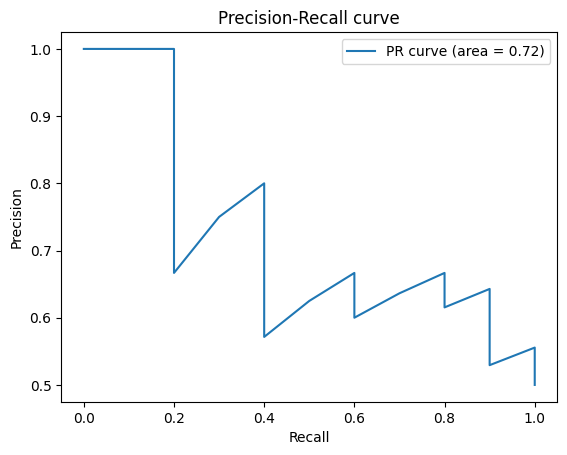

Area under the Precision-Recall curve: 0.72


In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

ranks = np.arange(1, 21)
labels = ['R', 'R', 'NR', 'R', 'R', 'NR','NR', 'R', 'R','NR',
          'R','R','NR','R','NR','NR','NR','R', 'NR', 'NR',]

df = pd.DataFrame({'Rank': ranks, 'Label': labels})

# Convert labels to binary format: R -> 1, NR -> 0
df['binary_label'] = df['Label'].map({'R': 1, 'NR': 0})

# Create predicted scores based on the rank
# Lower rank means higher relevance
df['score'] = -df['Rank']

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(df['binary_label'], df['score'])

# Compute AUC for the Precision-Recall curve
pr_auc = auc(recall, precision)


plt.figure()
plt.plot(recall, precision, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.savefig('precision_recall_curve.jpg', format='jpeg', bbox_inches='tight')
plt.show()

# Print the AUC
print(f'Area under the Precision-Recall curve: {pr_auc:.2f}')




Precision과 Recall이 각 순위에서 어떻게 계산되는지 단계별로 보여줍니다. 상위 10개 결과로 축소하여 계산 과정을 추적하기 쉽게 만들었는데, 5개가 관련 있고 5개가 관련 없는 것으로 설정했습니다. 이전 예제가 전체 커브를 그렸다면, 여기서는 각 컷오프 지점에서의 메트릭을 명시적으로 계산합니다.

`for i in range(1, len(df) + 1)`로 순위 1부터 10까지 반복하며, `sub_df = df.iloc[:i]`로 해당 순위까지의 결과만 선택합니다. 1위만 볼 때, 1-2위를 볼 때, 1-3위를 볼 때 등 점진적으로 확장하면서 메트릭이 어떻게 변하는지 관찰합니다. `tp = sum(sub_df['binary_label'])`은 True Positive로, 현재까지 검색된 결과 중 실제 관련 문서 개수입니다.

`fp = i - tp`는 False Positive로, 검색했지만 관련 없는 문서 개수를 나타냅니다. 상위 5개를 선택했는데 3개만 관련 있다면 fp는 2가 됩니다. `fn = sum(df['binary_label']) - tp`는 False Negative로, 전체 관련 문서 중 아직 검색되지 않은 개수입니다. 전체 5개 중 3개를 찾았다면 fn은 2입니다.

Precision 공식 `tp / (tp + fp)`는 검색된 것 중 정답 비율이고, Recall 공식 `tp / (tp + fn)`는 전체 정답 중 찾은 비율입니다. `if (tp + fp) > 0`로 0으로 나누는 예외를 방지합니다. 각 순위별 precision과 recall을 리스트에 추가한 후 데이터프레임에 열로 붙여서 최종 결과를 테이블 형태로 확인할 수 있습니다.

결과 데이터프레임을 보면 순위가 내려갈수록 recall은 증가하는데(더 많은 관련 문서를 찾음), precision은 변동하거나 감소하는 경향을 보입니다(관련 없는 문서도 섞임). RAG 시스템 튜닝 시 이 테이블로 특정 top-k 설정(예: top-5)에서의 정확한 성능을 파악하고, precision과 recall의 트레이드오프를 분석할 수 있습니다.

In [ ]:
# Calculate precision and recall for each rank
ranks = np.arange(1, 11)
labels = ['R', 'R', 'NR', 'R', 'R', 'NR','NR', 'R', 'NR','NR']

df = pd.DataFrame({'Rank': ranks, 'Label': labels})

# Convert labels to binary format: R -> 1, NR -> 0
df['binary_label'] = df['Label'].map({'R': 1, 'NR': 0})


precisions = []
recalls = []
for i in range(1, len(df) + 1):
    sub_df = df.iloc[:i]
    tp = sum(sub_df['binary_label'])
    fp = i - tp
    fn = sum(df['binary_label']) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)

df['precision'] = precisions
df['recall'] = recalls
df

,Rank,Label,binary_label,precision,recall
0,1,R,1,1.000000,0.2
1,2,R,1,1.000000,0.4
2,3,NR,0,0.666667,0.4
3,4,R,1,0.750000,0.6
4,5,R,1,0.800000,0.8
5,6,NR,0,0.666667,0.8
6,7,NR,0,0.571429,0.8
7,8,R,1,0.625000,1.0
8,9,NR,0,0.555556,1.0
9,10,NR,0,0.500000,1.0


# A RAG pipeline

In [ ]:
!wget https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/05.%20Vector%20Similarity/dataset/movies_metadata.csv

--2025-10-17 08:02:14--  https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/05.%20Vector%20Similarity/dataset/movies_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34445126 (33M) [text/plain]
Saving to: ‘movies_metadata.csv.1’

movies_metadata.csv 100%[===================>]  32.85M  85.2MB/s    in 0.4s    

2025-10-17 08:02:17 (85.2 MB/s) - ‘movies_metadata.csv.1’ saved [34445126/34445126]



영화 메타데이터를 담은 CSV 파일을 pandas로 불러와 첫 5개 행을 확인합니다. 이 데이터셋은 실제 RAG 파이프라인을 구축하기 위한 문서 소스로 사용될 예정입니다. `df.head()`는 데이터 구조를 파악하는 표준적인 첫 단계로, 어떤 열들이 있는지, 각 열의 데이터 타입은 무엇인지, 결측값은 있는지 등을 빠르게 점검할 수 있습니다.

AG 시스템 관점에서 특히 중요한 것은 텍스트 필드인데, 줄거리(overview)나 설명 같은 자연어 텍스트가 임베딩되어 검색 가능한 벡터 데이터베이스에 저장될 것입니다. 제목(title) 같은 메타데이터는 검색 결과를 사용자에게 표시할 때 식별자로 활용됩니다.

In [ ]:
import pandas as pd
df = pd.read_csv('movies_metadata.csv')
df.head()

/tmp/ipython-input-1841053763.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


RAG 시스템에 영화 데이터를 저장하는 과정입니다. `df[['original_title', 'overview']]`로 영화 제목과 줄거리 두 열만 추출합니다. `NLTKTextSplitter(chunk_size=1500)`는 줄거리 텍스트를 1500자 단위로 나누는데, 문장 중간에서 자르지 않고 문장 경계를 존중합니다.

`split_overview()` 함수는 각 영화의 줄거리를 청크로 분할하며, 줄거리가 없는 경우 빈 리스트를 반환합니다. `df['chunks']`에 저장하면 각 영화가 청크 리스트를 가지게 됩니다. `df.explode('chunks')`는 이 리스트를 펼쳐서 각 청크를 별도 행으로 만듭니다. 예를 들어 "Inception"이 2개 청크를 가지면, 1개 행이 2개 행으로 늘어나고 둘 다 제목은 "Inception"입니다.

빈 청크를 제거한 후 `SentenceTransformer('all-MiniLM-L6-v2')` 모델로 임베딩을 생성합니다. `embedder.encode()`에 모든 청크를 한 번에 넣고 `batch_size=256`으로 설정하면 내부적으로 256개씩 나눠서 처리합니다. 이렇게 하면 GPU 메모리를 초과하지 않으면서도 한 번에 하나씩 처리하는 것보다 훨씬 빠릅니다. 결과는 384차원 벡터들의 배열이고, 이를 데이터프레임의 `embeddings` 열에 저장합니다.

ChromaDB는 벡터를 저장하고 검색하는 데이터베이스입니다. `client.create_collection(name='movies')`로 'movies'라는 저장 공간을 만들고, 이미 있으면 삭제하고 새로 만듭니다. `collection.add()`로 데이터를 넣는데, `ids`는 각 청크를 구분하는 번호, `embeddings`는 벡터, `metadatas`는 나중에 검색 결과로 보여줄 제목과 텍스트를 담습니다. 데이터가 많으면 1000개씩 나눠서 넣고 진행 상황을 출력합니다.

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import NLTKTextSplitter
import chromadb
import nltk
nltk.download('punkt_tab')

df = df[['original_title', 'overview']]

# Step 1: Chunk the Overview Column using NLTKTextSplitter
text_splitter = NLTKTextSplitter(chunk_size=1500)

def split_overview(overview):
    if pd.isna(overview):
        return []
    return text_splitter.split_text(str(overview))

df['chunks'] = df['overview'].apply(split_overview)

# Flatten the dataframe for easier processing
chunked_df = df.explode('chunks').reset_index(drop=True)

# Step 2: Embed with a SentenceTransformer Encoder - 배치로 한번에 처리
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# 빈 청크 먼저 필터링
chunked_df = chunked_df[chunked_df['chunks'].notna() & (chunked_df['chunks'].str.strip() != '')]
chunked_df.reset_index(drop=True, inplace=True)

# 배치로 한번에 임베딩 (apply 대신)
embeddings = embedder.encode(
    chunked_df['chunks'].tolist(),
    batch_size=256,
    show_progress_bar=True,
    convert_to_numpy=True
)

chunked_df['embeddings'] = embeddings.tolist()

# Step 3: Store in ChromaDB
# Initialize ChromaDB client and collection
client = chromadb.Client()

# 기존 컬렉션 있으면 삭제
try:
    client.delete_collection(name='movies')
except:
    pass

collection = client.create_collection(name='movies')

# 배치로 나눠서 삽입
batch_size = 1000

for i in range(0, len(chunked_df), batch_size):
    batch = chunked_df.iloc[i:i+batch_size]

    collection.add(
        ids=[str(idx) for idx in batch.index],
        embeddings=batch['embeddings'].tolist(),
        metadatas=[{
            'original_title': row['original_title'],
            'chunk': row['chunks']
        } for _, row in batch.iterrows()]
    )

    print(f"Inserted batch {i//batch_size + 1}/{(len(chunked_df)-1)//batch_size + 1}")

print("Data successfully stored in ChromaDB.")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Batches:   0%|          | 0/174 [00:00<?, ?it/s]

Inserted batch 1/45
Inserted batch 2/45
Inserted batch 3/45
Inserted batch 4/45
Inserted batch 5/45
Inserted batch 6/45
Inserted batch 7/45
Inserted batch 8/45
Inserted batch 9/45
Inserted batch 10/45
Inserted batch 11/45
Inserted batch 12/45
Inserted batch 13/45
Inserted batch 14/45
Inserted batch 15/45
Inserted batch 16/45
Inserted batch 17/45
Inserted batch 18/45
Inserted batch 19/45
Inserted batch 20/45
Inserted batch 21/45
Inserted batch 22/45
Inserted batch 23/45
Inserted batch 24/45
Inserted batch 25/45
Inserted batch 26/45
Inserted batch 27/45
Inserted batch 28/45
Inserted batch 29/45
Inserted batch 30/45
Inserted batch 31/45
Inserted batch 32/45
Inserted batch 33/45
Inserted batch 34/45
Inserted batch 35/45
Inserted batch 36/45
Inserted batch 37/45
Inserted batch 38/45
Inserted batch 39/45
Inserted batch 40/45
Inserted batch 41/45
Inserted batch 42/45
Inserted batch 43/45
Inserted batch 44/45
Inserted batch 45/45
Data successfully stored in ChromaDB.


RAG 시스템의 검색과 생성 단계를 구현합니다. 먼저 쿼리를 임베딩할 `SentenceTransformer('all-MiniLM-L6-v2')` 모델을 로드하는데, 문서를 임베딩할 때와 동일한 모델을 사용해야 벡터 공간이 일치합니다. `BitsAndBytesConfig`로 양자화 설정을 구성하는데, `load_in_4bit=True`는 모델 가중치를 4비트로 압축하여 메모리 사용량을 크게 줄입니다.

`bnb_4bit_compute_dtype=torch.float16`은 계산은 float16으로 수행하고, `bnb_4bit_use_double_quant=True`는 이중 양자화로 추가 압축을 적용하며, `bnb_4bit_quant_type="nf4"`는 4비트 NormalFloat 포맷을 사용합니다. Mistral-7B 모델은 70억 개 파라미터를 가진 언어 모델인데, 양자화 없이는 28GB 정도 메모리가 필요하지만 4비트 양자화로 7GB 정도로 줄어듭니다.

`device_map='auto'`는 사용 가능한 GPU와 CPU에 모델을 자동으로 분배합니다. `pipeline()`으로 텍스트 생성 파이프라인을 만드는데, `task="text-generation"`으로 작업 유형을 지정하고, `return_full_text=True`는 프롬프트를 포함한 전체 텍스트를 반환하며, `max_new_tokens=800`은 생성할 최대 토큰 수를 제한합니다.

`retrieve_documents()` 함수는 사용자 쿼리를 받아 벡터로 변환합니다. `sentence_model.encode(query).tolist()`로 쿼리를 384차원 벡터로 만들고, `collection.query()`로 ChromaDB에서 가장 유사한 top_k개 문서를 검색합니다. `query_embeddings`는 리스트 형태로 전달해야 하며, `n_results=5`는 상위 5개 결과를 요청합니다. 검색 결과의 `metadatas[0]`에서 청크 텍스트와 영화 제목을 추출하여 두 개의 리스트로 반환합니다.

`generate_answer()` 함수는 검색된 청크들을 컨텍스트로 조합합니다. `"\n\n".join()`으로 각 청크를 제목과 함께 포맷팅하여 하나의 문자열로 만듭니다. 프롬프트는 Mistral 모델의 지시 포맷인 `[INST]...[/INST]`를 따르며, 시스템에게 영화 추천 전문가 역할을 부여하고 쿼리와 컨텍스트를 제공합니다. `text_generation_pipeline(prompt)`는 이 프롬프트를 모델에 입력하여 답변을 생성하고, 결과는 딕셔너리 리스트 형태로 반환되므로 `[0]['generated_text']`로 텍스트를 추출합니다.

마지막 부분은 사용 예시로, ChromaDB 클라이언트를 다시 연결하고 'movies' 컬렉션을 가져옵니다. "What are some good movies to watch on a rainy day?" 쿼리로 5개 문서를 검색하여 청크와 제목을 출력합니다. 실제로는 이후 `generate_answer()`를 호출하여 최종 답변을 생성하겠지만 여기서는 검색 결과만 확인합니다.

In [ ]:
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from chromadb import Client
from sentence_transformers import SentenceTransformer
import chromadb
import torch

# Load the SentenceTransformer model for encoding queries
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')  # Use the same model as for embedding documents

# 양자화 설정
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

# Load the text generation model and tokenizer with quantization
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    device_map='auto',
    quantization_config=quantization_config
)
text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    max_new_tokens=800
)


# Function to retrieve top_k documents from ChromaDB
def retrieve_documents(query, collection, top_k=5):
    # Embed the query using the SentenceTransformer model
    query_embedding = sentence_model.encode(query).tolist()

    # Search for top_k similar documents in the collection
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=top_k
    )

    if not results['documents']:
        print("No results found for the query.")
        return [], []

    # Extract chunks and titles from the results
    chunks = []
    titles = []
    for document in results['metadatas'][0]:
        chunks.append(document['chunk'])
        titles.append(document['original_title'])

    return chunks, titles

# Function to generate answer based on retrieved chunks and titles
def generate_answer(query, chunks, titles, text_generation_pipeline):
    # Prepare the context from chunks and titles
    context = "\n\n".join([f"Title: {title}\nChunk: {chunk}" for title, chunk in zip(titles, chunks)])

    # Prepare the prompt
    prompt = f"""[INST]
    Instruction: You're an expert in movie suggestions. Your task is to analyze carefully the context and come up with an exhaustive answer to the following question:
    {query}

    Here is the context to help you:

    {context}

    [/INST]"""

    # Generate the answer using the model
    generated_text = text_generation_pipeline(prompt)[0]['generated_text']

    return generated_text

# Example usage
client = chromadb.Client()
collection = client.get_collection(name='movies')

query = "What are some good movies to watch on a rainy day?"
top_k = 5

# Retrieve documents
chunks, titles = retrieve_documents(query, collection, top_k)
print(f"Retrieved Chunks: {chunks}")
print(f"Retrieved Titles: {titles}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Retrieved Chunks: ['One rainy day, Heathcliff babysits and recounts old stories while his nephews are relucatantly forced to listen.', 'Lizzy (Candice Bergen), a liberated American photographer, falls for narrow-minded journalist Paolo (Giancarlo Giannini).\n\nThen finds she can\'t live with him or without him.\n\nBergen (Murphy Brown) and Giannini (Seven Beauties) take both comic and fierce battle stations in this colorful excursion into the male/female combat zone.\n\nSo what if the world, as we learn from the TV in Lizzy and Paolo\'s luxurious apartment, is crashing around their ears; this is WAR!\n\nWriter/director Lina Wertmuller relied on spontaneity and improvisation in making ...A Night Full of Rain, her first film in English.\n\nGiannini, star of Wertmuller\'s groundbreaking Swept Away and Seven Beauties, was familiar with the technique, Bergen wasn\'t.\n\nBut it worked splendidly.\n\n"Bergen gives one of the warmest and most characterful performances of her career," the Los A

`if chunks and titles:`는 두 리스트가 모두 비어있지 않은지 체크합니다. 검색이 실패하거나 관련 문서가 없으면 빈 리스트가 반환되므로 이 조건은 False가 됩니다. 조건이 참이면 `generate_answer()`를 호출하여 쿼리, 검색된 청크들, 영화 제목들, 그리고 텍스트 생성 파이프라인을 전달합니다. 함수 내부에서 Mistral 모델이 검색된 영화 정보를 바탕으로 "비 오는 날 볼 만한 영화"에 대한 답변을 생성합니다. 생성된 답변은 프롬프트 전체를 포함하므로, 실제 응답 부분만 파싱하려면 추가 처리가 필요할 수 있습니다.

검색 결과가 없으면 else 블록이 실행되어 사용자에게 관련 문서를 찾지 못했다고 알립니다. 이는 쿼리가 데이터베이스의 어떤 영화와도 유사하지 않거나, 컬렉션이 비어있을 때 발생합니다. 이것이 RAG의 핵심 흐름으로, Retrieval로 관련 정보를 찾고 Augmented로 그 정보를 프롬프트에 추가하며 Generation으로 최종 답변을 만들어냅니다.

In [ ]:
# Generate answer
if chunks and titles:
    answer = generate_answer(query, chunks, titles, text_generation_pipeline)
    print(answer)
else:
    print("No relevant documents found to generate an answer.")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST]
    Instruction: You're an expert in movie suggestions. Your task is to analyze carefully the context and come up with an exhaustive answer to the following question:
    What are some good movies to watch on a rainy day?
    
    Here is the context to help you:

    Title: Heathcliff: The Movie
Chunk: One rainy day, Heathcliff babysits and recounts old stories while his nephews are relucatantly forced to listen.

Title: La fine del mondo nel nostro solito letto in una notte piena di pioggia
Chunk: Lizzy (Candice Bergen), a liberated American photographer, falls for narrow-minded journalist Paolo (Giancarlo Giannini).

Then finds she can't live with him or without him.

Bergen (Murphy Brown) and Giannini (Seven Beauties) take both comic and fierce battle stations in this colorful excursion into the male/female combat zone.

So what if the world, as we learn from the TV in Lizzy and Paolo's luxurious apartment, is crashing around their ears; this is WAR!

Writer/director Lina We